In [16]:
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


file_path = "Z:/Shared/Amichai/Behavior/data/Group_2\G2A1\GNG\Session Data\G2A1_GNG_20250116_083652.mat"


In [17]:
import numpy as np
import scipy.io

def read_and_preprocess(file_path):
    print(f"Processing file: {file_path}")  # Debugging info
    
    try:
        # Load the .mat file
        mat_contents = scipy.io.loadmat(file_path)
        
        # Extract the 'SessionData' field safely
        if 'SessionData' not in mat_contents:
            print("Missing 'SessionData' in .mat file")
            return None
        
        session_data_content = mat_contents['SessionData'][0, 0]
        
        # Extract fields safely using dictionary-style indexing
        trial_types = session_data_content['TrialTypes'][0] if 'TrialTypes' in session_data_content.dtype.names else None
        raw_events = session_data_content['RawEvents'][0, 0] if 'RawEvents' in session_data_content.dtype.names else None
        outcome = session_data_content['Outcome'][0] if 'Outcome' in session_data_content.dtype.names else np.array([])
        stimuli = session_data_content['stimulus'][0] if 'stimulus' in session_data_content.dtype.names else np.array([])

        # Handle missing or empty arrays
        if trial_types is None or raw_events is None:
            print("Missing 'TrialTypes' or 'RawEvents'")
            return None

        trial = raw_events['Trial']

        # Initialize arrays
        n_trials = len(trial_types)
        licks = [None] * n_trials  
        time_to_lick = np.full(n_trials, np.nan)  

        for i in range(n_trials):
            try:
                trial_element = trial[0, i]  
                nested_structure = trial_element[0, 0]  

                if 'Events' in nested_structure.dtype.names:
                    events = nested_structure['Events'][0, 0]  

                    if 'HiFi1_1' in events.dtype.names:
                        stim_t = np.min(events['HiFi1_1'][0])  
                    else:
                        stim_t = None  
                    
                    if 'Port1In' in events.dtype.names and stim_t is not None:
                        lick = events['Port1In'][0] 
                        lick_after_stim = lick[lick > stim_t]
                        
                        if lick_after_stim.size > 0:
                            time_to_lick[i] = lick_after_stim[0] - stim_t  
                            licks[i] = lick_after_stim - stim_t 
            except Exception as e:
                print(f"Error processing trial {i}: {e}")
        
        # Ensure stimuli is an array before filtering
        if not isinstance(stimuli, np.ndarray):
            stimuli = np.array(stimuli)

        unique_stims = np.unique(stimuli)
        
        grouped_data = []
        grouped_data_mean = []
        for s in unique_stims:
            try:
                # Fixing ambiguous boolean mask evaluation
                mask = np.logical_and(stimuli == s, ~np.isnan(time_to_lick))

                if np.any(mask):  # Ensure mask contains valid data
                    valid_times = time_to_lick[mask]
                    grouped_data.append(valid_times)
                    grouped_data_mean.append(np.nanmean(valid_times) if valid_times.size > 0 else np.nan)
                else:
                    grouped_data.append(np.array([]))
                    grouped_data_mean.append(np.nan)
            except Exception as e:
                print(f"Error processing stimulus {s}: {e}")

        grouped_data_mean = np.array(grouped_data_mean)
        
        # Fix outcome-related error
        lick_rates = []
        for stimulus in unique_stims:
            try:
                # Fix boolean indexing issue
                mask = np.where(stimuli == stimulus)[0]  # Get valid indices
                
                if outcome.size > 0 and mask.size > 0:
                    relevant_outcomes = outcome[mask]
                    lick = np.sum(np.isin(relevant_outcomes, [1, -1]))  
                    lick_rate = (lick / len(relevant_outcomes)) if len(relevant_outcomes) > 0 else 0  
                else:
                    lick_rate = 0  # No valid trials for this stimulus
                
                lick_rates.append(lick_rate)
            except Exception as e:
                print(f"Error processing lick rates for stimulus {stimulus}: {e}")
        
        lick_rates = np.array(lick_rates)

        return time_to_lick, licks, outcome, trial_types, stimuli, unique_stims, grouped_data, grouped_data_mean, lick_rates

    except Exception as e:
        print(f"Critical error in file {file_path}: {e}")
        return None


In [18]:
time_to_lick, licks, outcome, trial_types, stimuli, unique_stims, grouped_data, grouped_data_mean, lick_rates  = read_and_preprocess(file_path)
# Remove NaN values
valid_time_to_lick = time_to_lick[~np.isnan(time_to_lick)]


Processing file: Z:/Shared/Amichai/Behavior/data/Group_2\G2A1\GNG\Session Data\G2A1_GNG_20250116_083652.mat


In [5]:
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation
# from IPython.display import HTML
# 
# # Ensure stimuli and time_to_lick are numpy arrays
# stimuli = np.array(stimuli)
# time_to_lick = np.array(time_to_lick)
# 
# # Remove NaNs from time_to_lick while keeping the corresponding stimuli
# valid_indices = ~np.isnan(time_to_lick)
# stimuli = stimuli[valid_indices]
# time_to_lick = time_to_lick[valid_indices]
# 
# window_size = 30  # Number of data points per window
# num_windows = 10  # Number of overlapping windows
# step_size = max(len(time_to_lick) // num_windows, 1)  # Step size for overlap
# 
# # Prepare windows
# windows = []
# for w in range(num_windows):
#     start_idx = w * step_size
#     end_idx = min(start_idx + window_size, len(time_to_lick))
#     
#     if start_idx >= end_idx:
#         break  # Stop if window is out of bounds
# 
#     batch_data = time_to_lick[start_idx:end_idx]
#     batch_stim = stimuli[start_idx:end_idx]
# 
#     unique_stims = np.unique(batch_stim)
#     grouped_data = [batch_data[batch_stim == s] for s in unique_stims]
#     formatted_stim_labels = [f"{s:.3f}" for s in unique_stims]
#     
#     windows.append((grouped_data, formatted_stim_labels))
# 
# # Create figure
# fig, ax = plt.subplots(figsize=(8, 6))
# 
# def update(frame):
#     ax.clear()  # Clear previous frame
#     grouped_data, formatted_stim_labels = windows[frame]
# 
#     # Create boxplot
#     ax.boxplot(grouped_data, labels=formatted_stim_labels, patch_artist=True, showfliers=False,
#                boxprops=dict(facecolor='skyblue', color='black'), medianprops=dict(color='black'))
# 
#     # Scatter plot with jitter
#     for i, stim_data in enumerate(grouped_data):
#         jitter = np.random.normal(0, 0.05, size=len(stim_data))
#         ax.scatter(np.full(len(stim_data), i + 1) + jitter, stim_data, 
#                    color='gray', alpha=0.5, s=10)
# 
#     # Set y-axis limit
#     ax.set_ylim(0, 2.5)
# 
#     # Labels and title
#     ax.set_xlabel('Frequency (kHz)', fontsize=12)
#     ax.set_ylabel('Time to First Lick (ms)', fontsize=12)
#     ax.set_title(f'Window {frame + 1}/{num_windows}')
#     ax.grid(axis='y', linestyle='--', alpha=0.7)
# 
# # Create animation
# ani = animation.FuncAnimation(fig, update, frames=len(windows), repeat=True, interval=1000)
# 
# # Display animation in Jupyter Notebook
# HTML(ani.to_jshtml())


In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Define colors for Go and No-Go
c_go = np.array([0, 104, 55]) / 255  # Dark Green
c_nogo = np.array([165, 0, 38]) / 255  # Dark Red

def time2lick(time_to_lick, trial_types, plot=False):
    """
    Computes and optionally plots histograms of time-to-first-lick for Go and No-Go trials.

    Parameters:
    - time_to_lick (numpy array): Array of time to first lick per trial.
    - trial_types (numpy array): Corresponding trial types (1 = Go, 2 = No-Go).
    - plot (bool): Whether to plot histograms.

    Returns:
    - counts (dict): Dictionary containing histogram counts for Go and No-Go trials.
    - valid_time_to_lick (dict): Dictionary containing filtered (non-NaN) time-to-lick data.
    """
    # Separate Go and No-Go trials
    time_to_lick_go = time_to_lick[trial_types == 1]
    time_to_lick_nogo = time_to_lick[trial_types == 2]

    # Remove NaN values
    valid_time_to_lick_go = time_to_lick_go[~np.isnan(time_to_lick_go)]
    valid_time_to_lick_nogo = time_to_lick_nogo[~np.isnan(time_to_lick_nogo)]

    # Store results
    counts = {}
    valid_time_to_lick = {
        "Go": valid_time_to_lick_go,
        "No-Go": valid_time_to_lick_nogo
    }

    if plot:
        # ✅ Create histogram plot
        plt.figure(figsize=(8, 5))

        # ✅ Plot No-Go histogram
        counts_nogo, bins_nogo, patches_nogo = plt.hist(
            valid_time_to_lick_nogo, bins=20, color=c_nogo, edgecolor='black',
            weights=np.ones_like(valid_time_to_lick_nogo) * 100 / len(valid_time_to_lick_nogo), alpha=0.7, label="No-Go"
        )
        counts["No-Go"] = counts_nogo

        # ✅ Plot Go histogram
        counts_go, bins_go, patches_go = plt.hist(
            valid_time_to_lick_go, bins=20, color=c_go, edgecolor='black',
            weights=np.ones_like(valid_time_to_lick_go) * 100 / len(valid_time_to_lick_go), alpha=0.7, label="Go"
        )
        counts["Go"] = counts_go


        # ✅ Plot formatting
        plt.ylim(0, 100)
        plt.xlabel('Time to First Lick (ms)')
        plt.ylabel('Percentage (%)')
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # ✅ Display trial counts in title
        plt.title(f"n-trials (Go: {len(valid_time_to_lick_go)}, No-Go: {len(valid_time_to_lick_nogo)})")

        plt.show()

    return counts, valid_time_to_lick


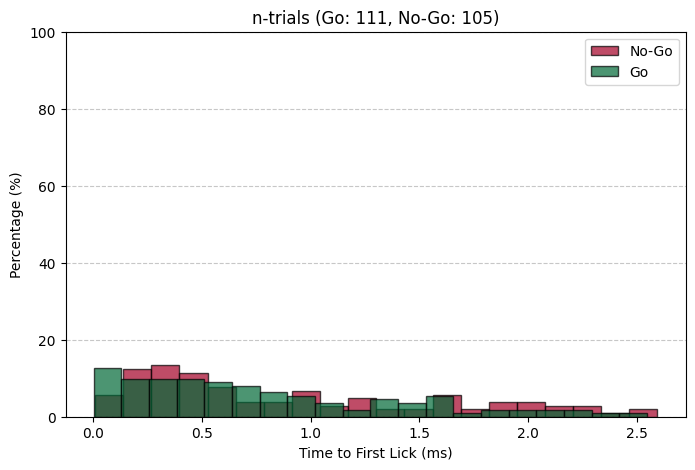

({'No-Go': array([ 5.71428571, 12.38095238, 13.33333333, 11.42857143,  7.61904762,
          3.80952381,  3.80952381,  6.66666667,  2.85714286,  4.76190476,
          1.9047619 ,  1.9047619 ,  5.71428571,  1.9047619 ,  3.80952381,
          3.80952381,  2.85714286,  2.85714286,  0.95238095,  1.9047619 ]),
  'Go': array([12.61261261,  9.90990991,  9.90990991,  9.90990991,  9.00900901,
          8.10810811,  6.30630631,  5.40540541,  3.6036036 ,  1.8018018 ,
          4.5045045 ,  3.6036036 ,  5.40540541,  0.9009009 ,  1.8018018 ,
          1.8018018 ,  1.8018018 ,  1.8018018 ,  0.9009009 ,  0.9009009 ])},
 {'Go': array([5.8610e-01, 1.3235e+00, 1.5708e+00, 1.5564e+00, 3.7300e-01,
         5.3980e-01, 3.3030e-01, 4.5050e-01, 3.6610e-01, 6.3040e-01,
         2.6940e-01, 1.6096e+00, 1.0134e+00, 2.2680e-01, 5.8900e-01,
         2.0148e+00, 7.3410e-01, 1.0830e-01, 7.6940e-01, 1.0580e+00,
         4.3510e-01, 6.8160e-01, 4.8090e-01, 3.7800e-02, 6.5130e-01,
         7.6100e-02, 6.5700e-01, 1.01

In [7]:
time2lick(time_to_lick, trial_types,  plot = True)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import ks_2samp

# Define custom colors
c_go = np.array([0, 104, 55]) / 255  # Dark Green
c_nogo = np.array([165, 0, 38]) / 255  # Dark Red

def plot_lick_raster_and_histogram(licks, trial_types):
    """
    Plots a raster plot and histograms of Go and No-Go trial licks.
    
    Parameters:
    - licks (list or numpy array): Array of lick times for each trial.
    - trial_types (numpy array): Array indicating trial type (1 = Go, 2 = No-Go).
    """
    
    # Ensure `licks` is a NumPy array (object type for mixed-size arrays)
    licks = np.array(licks, dtype=object)  # Convert to NumPy array for proper indexing
    go_trial = (trial_types == 1)  # Boolean mask for Go trials
    no_go_trial = (trial_types == 2)  # Boolean mask for No-Go trials

    # Extract Go and No-Go licks
    go_licks = licks[go_trial]  
    no_go_licks = licks[no_go_trial]  

    # ✅ Function to filter out None and empty arrays
    def filter_valid_arrays(data):
        return [arr for arr in data if isinstance(arr, np.ndarray) and arr.ndim == 1 and arr.size > 0]

    # Filter valid Go and No-Go licks
    filtered_go_licks = filter_valid_arrays(go_licks)
    filtered_no_go_licks = filter_valid_arrays(no_go_licks)

    # ✅ Concatenate only if valid arrays exist
    concatenated_go = np.concatenate(filtered_go_licks) if filtered_go_licks else np.array([])
    concatenated_no_go = np.concatenate(filtered_no_go_licks) if filtered_no_go_licks else np.array([])

    # Assign trial indices
    go_indices = np.where(go_trial)[0]  # Indices of Go trials
    no_go_indices = np.where(no_go_trial)[0]  # Indices of No-Go trials

    # ✅ Sort trials: Go on top, No-Go below
    sorted_trial_indices = list(go_indices) + list(no_go_indices)  # Go first, then No-Go
    sorted_licks = filtered_go_licks + filtered_no_go_licks  # Keep as a list (NO concatenation)
    sorted_trial_labels = ["Go"] * len(filtered_go_licks) + ["No-Go"] * len(filtered_no_go_licks)  # Labels

    # ✅ Perform KS test
    if len(concatenated_go) > 0 and len(concatenated_no_go) > 0:
        ks_stat, ks_p = ks_2samp(concatenated_go, concatenated_no_go)

        # Convert p-value to significance level using asterisks
        if ks_p < 0.001:
            significance_text = "***"
        elif ks_p < 0.01:
            significance_text = "**"
        elif ks_p < 0.05:
            significance_text = "*"
        else:
            significance_text = "n.s."  # Not significant
    else:
        ks_p = None
        significance_text = "N/A (insufficient data)"

    # ✅ Create a figure with shared x-axis
    fig = plt.figure(figsize=(12, 8))
    gs = GridSpec(2, 1, height_ratios=[2, 1])  # Raster plot larger

    # ✅ Raster Plot (Top)
    ax_raster = fig.add_subplot(gs[0, 0])
    for trial_idx, (licks_in_trial, trial_type) in enumerate(zip(sorted_licks, sorted_trial_labels)):
        if isinstance(licks_in_trial, np.ndarray) and licks_in_trial.size > 0:
            color = c_go if trial_type == "Go" else c_nogo
            ax_raster.scatter(
                licks_in_trial,
                [len(sorted_trial_indices) - trial_idx] * len(licks_in_trial), 
                color=color, s=10
            )
    ax_raster.set_ylabel("Trial Index (Sorted)")
    ax_raster.grid(axis='x', linestyle="--", alpha=0.6)

    # ✅ Histograms (Bottom)
    ax_hist = fig.add_subplot(gs[1, 0], sharex=ax_raster)

    # ✅ Use provided function to plot histogram
    def plot_histogram(ax, data, color, title):
        if len(data) > 0:
            counts, bins, patches = ax.hist(data, bins=30, alpha=0.7, color=color, edgecolor='black', density=True)
            counts = 100 * counts / counts.sum()  # Convert to percentage
            for patch, count in zip(patches, counts):
                patch.set_height(count)  # Update height with percentage
                # ax.text(patch.get_x() + patch.get_width() / 2, count + 0.5, f'{count:.1f}%', 
                #         ha='center', fontsize=8, color='black')

        ax.set_xlabel("Time from Tone (s)")
        ax.set_ylabel("Percentage" if ax == ax_hist else "")  # Only left plot gets label
        ax.set_title(title)
        ax.grid(axis='y', linestyle='--', alpha=0.7)  # ✅ Only horizontal grid lines
        ax.set_ylim(0, 30)  # Auto-scale y-axis

    # Plot Go and No-Go histograms
    plot_histogram(ax_hist, concatenated_no_go, c_nogo, "No-Go Trial Licks")
    plot_histogram(ax_hist, concatenated_go, c_go, "Go Trial Licks")

    # ✅ Add significance annotation (asterisks) on top of the plots
    fig.suptitle(f"KS Test: {significance_text}", fontsize=16, fontweight='bold', y=1.05)

    # Adjust layout
    plt.tight_layout()
    plt.show()


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def psychometric_fitting(unique_stims, data_points, toplim, plot=False):
    
    def replace_nan_with_flanking_avg(data):
        """
        Replace NaN values in an array with the average of the two neighboring values.
        If NaN is at the start or end, it remains unchanged.
        """
        data = np.array(data, dtype=np.float64)  # Ensure it's a NumPy array of floats
        
        nan_indices = np.where(np.isnan(data))[0]  # Find indices of NaNs

        for i in nan_indices:
            if 0 < i < len(data) - 1:  # Avoid first and last indices
                if not np.isnan(data[i - 1]) and not np.isnan(data[i + 1]):  # Ensure flanking values exist
                    data[i] = (data[i - 1] + data[i + 1]) / 2

        return data

    # Fix NaNs in data_points
    if np.any(np.isnan(data_points)):
        data_points = replace_nan_with_flanking_avg(data_points)

    # Ensure both unique_stims and data_points contain only valid (finite) values
    valid_mask = np.isfinite(unique_stims) & np.isfinite(data_points)
    unique_stims = unique_stims[valid_mask]
    data_points = data_points[valid_mask]

    # Check again if valid data exists
    if len(unique_stims) < 3 or len(data_points) < 3:
        raise ValueError("Insufficient valid data for curve fitting. Check for excessive NaNs or Infs.")

    # Define the sigmoid function
    def sigmoid(x, L, x0, k):
        return L / (1 + np.exp(-k * (x - x0)))

    # Fit the sigmoid function
    try:
        popt, _ = curve_fit(
            sigmoid,
            unique_stims,
            data_points,
            p0=[max(data_points), np.median(unique_stims), 1],
            maxfev=10000  # Increase iterations if needed
        )
    except RuntimeError:
        raise RuntimeError("Curve fitting failed. Check your data for validity.")
    except Exception as e:
        raise ValueError(f"Unexpected error in curve fitting: {e}")

    # Extract fitted parameters
    L, x0, k = popt  # L: max value, x0: inflection point, k: steepness

    # Calculate the slope at the inflection point (x0)
    slope_at_midpoint = (L * k) / 4

    # Calculate the slope at the **median of unique_stims**
    x_median = np.median(unique_stims)
    slope_at_median = (L * k * np.exp(-k * (x_median - x0))) / ((1 + np.exp(-k * (x_median - x0))) ** 2)
       
    # Optional: Plot the sigmoid curve and annotate the slopes
    x_fit = np.linspace(min(unique_stims), max(unique_stims), 100)
    y_fit = sigmoid(x_fit, *popt)

    if plot:
        plt.figure(figsize=(8, 6))
        plt.plot(unique_stims, data_points, 'o', label='Data')  # Original data points
        plt.plot(x_fit, y_fit, '-', label='Sigmoid Fit', color='gray')  # Fitted sigmoid curve
        plt.axvline(x=x_median, linestyle='--', color='black', label=f'Median (x={x_median:.2f})')

        # Annotate slopes
        plt.text(x_median, sigmoid(x_median, *popt), f'Slope at median: {slope_at_median:.2f}', color='black')

        # Add labels and title
        plt.xlabel('Stimulus')
        plt.ylabel('Average Time to First Lick (ms)')
        plt.title('Sigmoid Fit and Slopes')

        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.legend(fontsize=10)
        plt.ylim(0, toplim)
        plt.show()
    
    return x0, slope_at_midpoint, slope_at_median


In [10]:
def getOutcome(row):
    outcome = row.get('Outcomes', None)
    outcome = outcome.strip("[]\n").split()
    
    # Reconstruct properly formatted strings
    cleaned_responses = []
    temp_word = []
    
    for word in outcome:
        clean_word = word.strip("',")  # Remove extra quotes and commas
        if clean_word == "Alarm":  # Handle "False Alarm" case
            temp_word.append(clean_word)
            cleaned_responses.append(" ".join(temp_word))
            temp_word = []
        elif clean_word == "False":
            temp_word.append(clean_word)
        else:
            cleaned_responses.append(clean_word)
    
    # Mapping of response types to numerical values
    response_mapping = {
        'CR': -2,
        'False Alarm': -1,
        'Miss': 0,
        'Hit': 1
    }
    
    # Convert responses to numerical values
    numerical_responses = [response_mapping[resp] for resp in cleaned_responses]
    
    return numerical_responses

In [11]:
group1_data = pd.read_csv(r"G:\My Drive\Study\Lab\Projects\Code_temp\users_data\Amichai\Group 1_experimental_data.csv")
group2_data = pd.read_csv(r"G:\My Drive\Study\Lab\Projects\Code_temp\users_data\Amichai\Group 2_experimental_data.csv")

data = pd.concat([group1_data, group2_data])


In [12]:

# Define the function to convert string representation of Stimuli to a numeric array
def stim2_num(row):
    if isinstance(row['Stimuli'], str):  # Only process if Stimuli is a string
        stimuli = row['Stimuli'].strip("[]\n").split()  # Remove brackets and split the string
        stimuli = np.array([float(num) for num in stimuli])  # Convert to a numpy array of floats
        return stimuli  # Return the numeric array
    return row['Stimuli']  # If already numeric, return as is

# Apply the function to convert the Stimuli column into numeric arrays
data['Stimuli'] = data.apply(stim2_num, axis=1)

# Function to check if a row has more than 2 unique values in Stimuli
def check_unique_and_add_cat(row):
    stimuli = row['Stimuli']
    if len(np.unique(stimuli)) > 2:  # Check if there are more than 2 unique values
        if pd.isna(row['Notes']):  # If Notes column is empty
            return "cat"
        else:  # Append "cat" if Notes already has some value
            return f"{row['Notes']}, cat"
    return row['Notes']  # If condition is not met, keep Notes unchanged

# Apply the check_unique_and_add_cat function to the Notes column
data['Notes'] = data.apply(check_unique_and_add_cat, axis=1)
# Filter rows where Notes contains 'cat'
cat_data = data[(data['Notes'].notna()) & (data['Notes'].str.contains("cat", na=False))]



Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A2\GNG\Session Data\G1A2_GNG_20241125_123642.mat


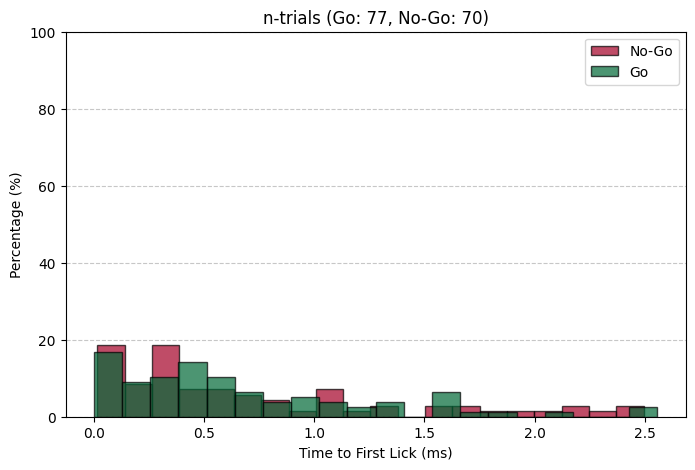

C:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A3\GNG\Session Data\G1A3_GNG_20241125_132855.mat


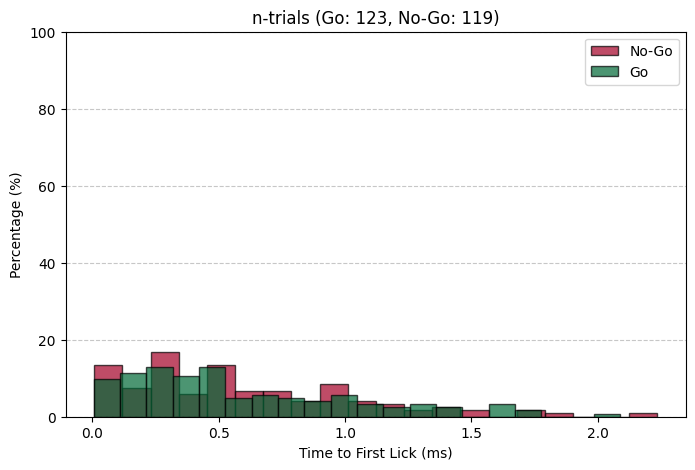

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A4\GNG\Session Data\G1A4_GNG_20241125_140701.mat


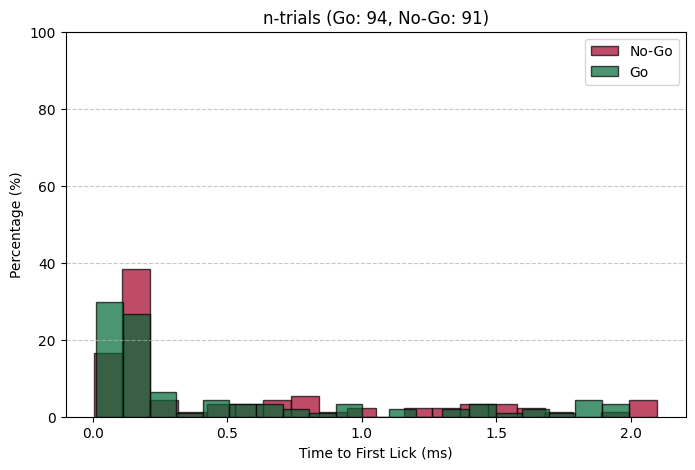

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A2\GNG\Session Data\G1A2_GNG_20241126_083915.mat


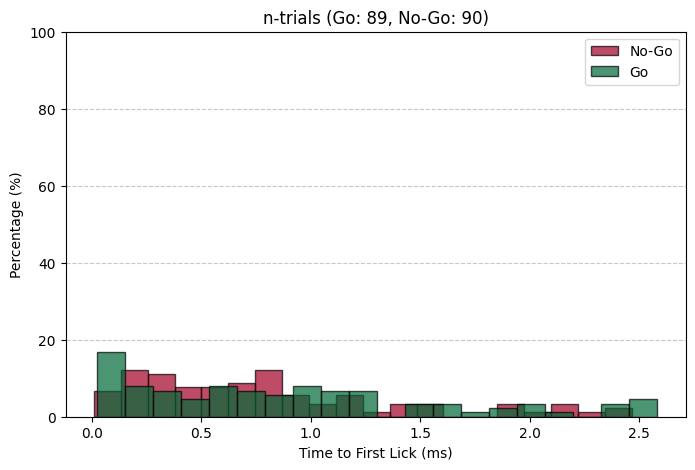

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A3\GNG\Session Data\G1A3_GNG_20241126_091515.mat


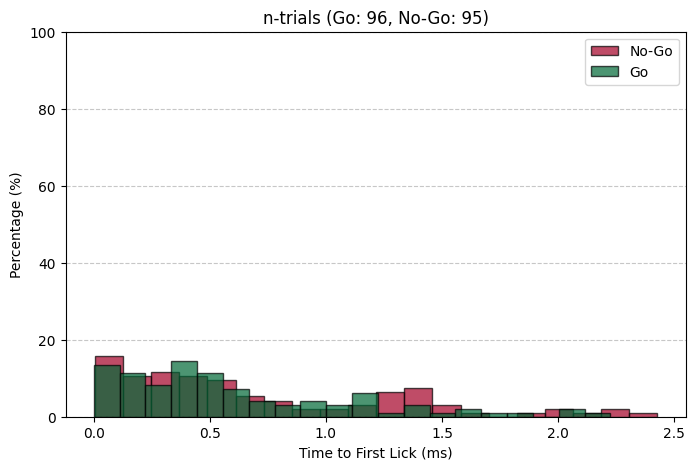

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A4\GNG\Session Data\G1A4_GNG_20241126_094436.mat


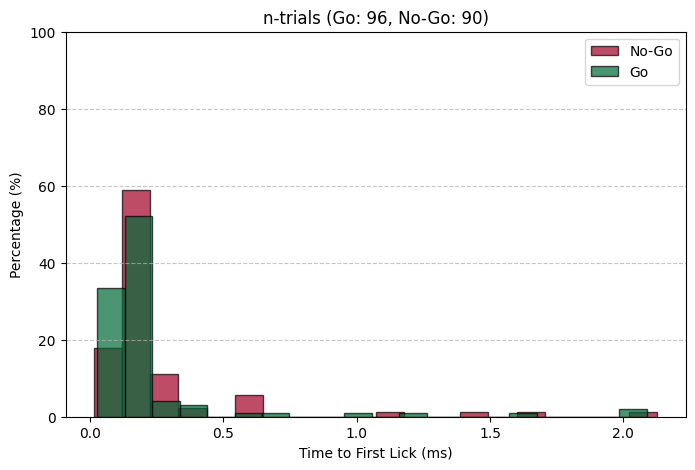

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A2\GNG\Session Data\G1A2_GNG_20241126_101313.mat


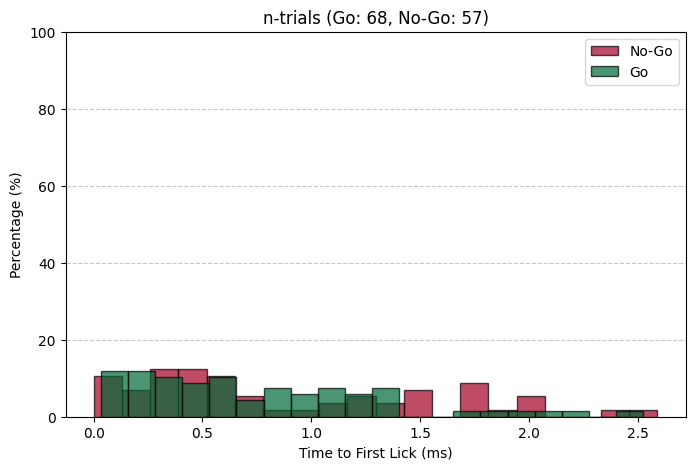

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A3\GNG\Session Data\G1A3_GNG_20241126_104048.mat


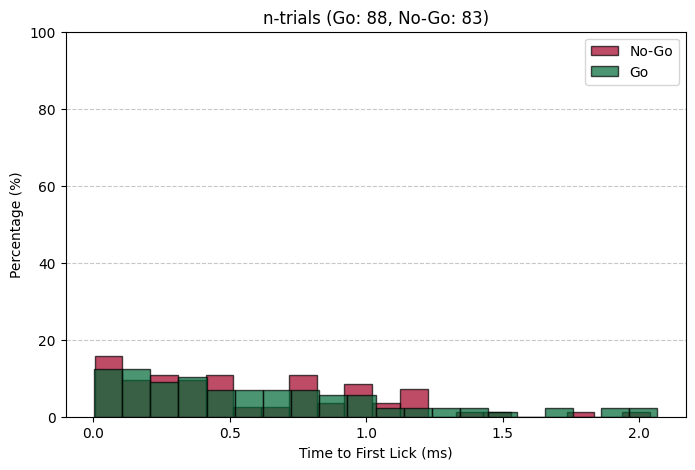

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A4\GNG\Session Data\G1A4_GNG_20241126_111139.mat


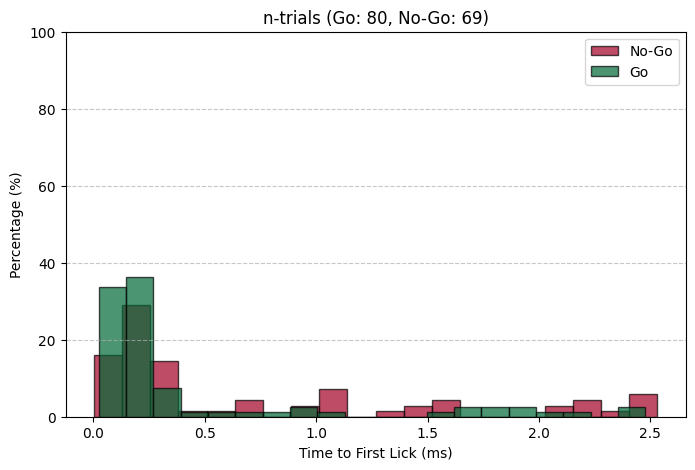

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A2\GNG\Session Data\G1A2_GNG_20241127_084830.mat


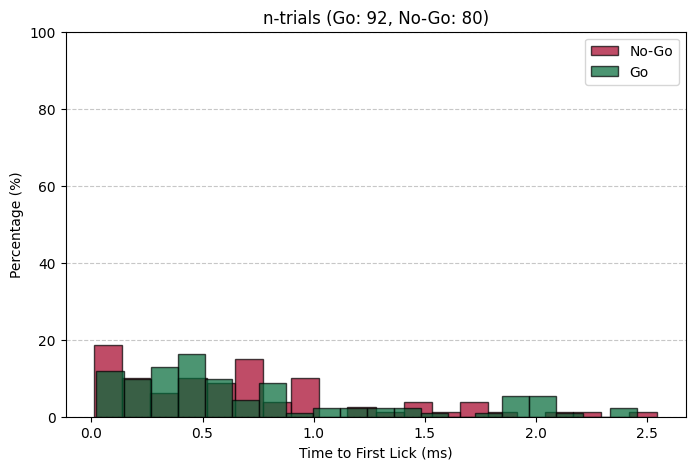

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A4\GNG\Session Data\G1A4_GNG_20241127_094810.mat


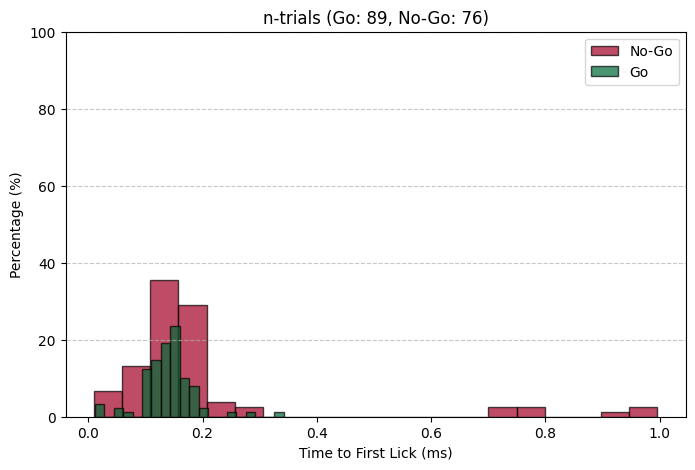

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A3\GNG\Session Data\G1A3_GNG_20241128_121945.mat


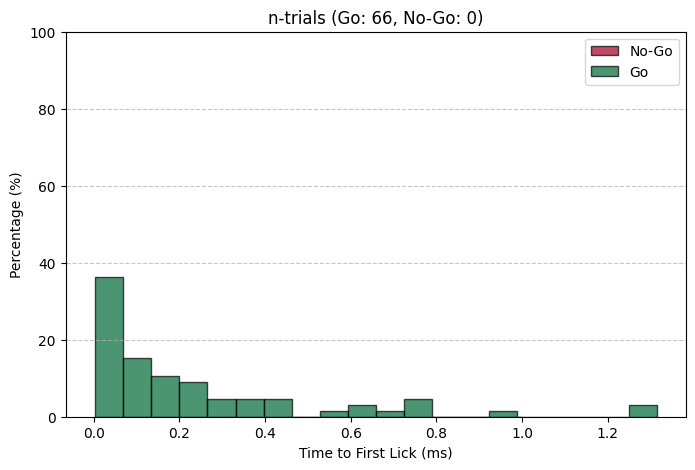

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A2\GNG\Session Data\G1A2_GNG_20241201_084900.mat


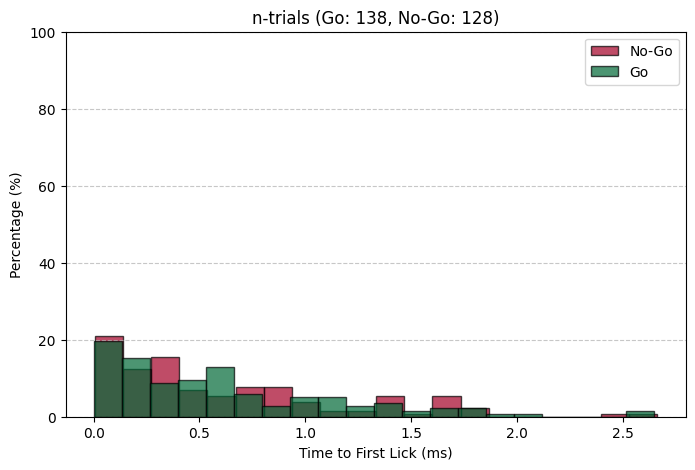

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A4\GNG\Session Data\G1A4_GNG_20241201_111409.mat


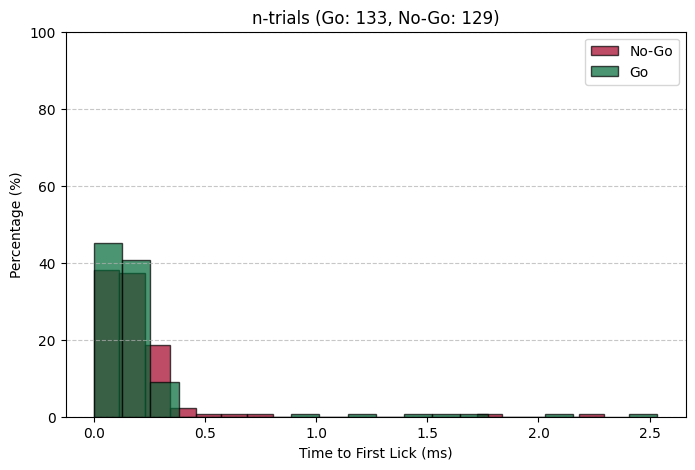

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A2\GNG\Session Data\G1A2_GNG_20241201_121023.mat


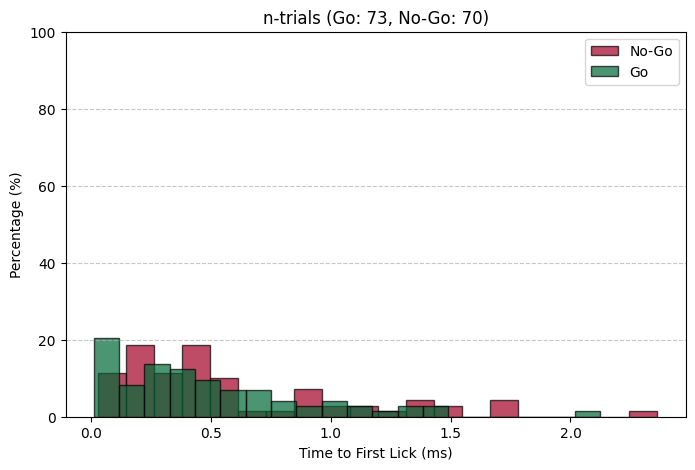

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A4\GNG\Session Data\G1A4_GNG_20241201_134307.mat


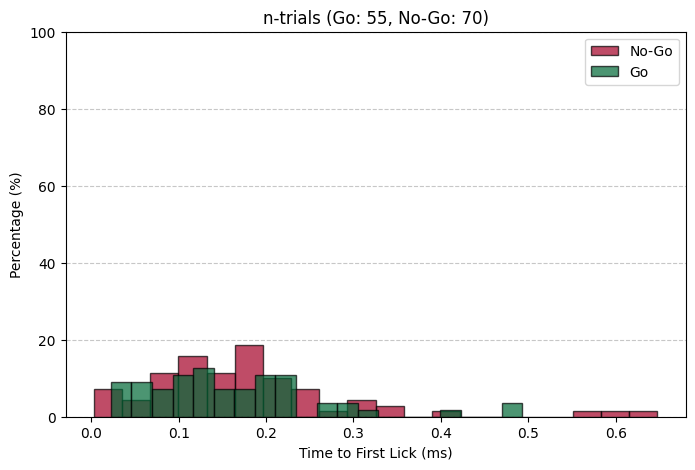

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A2\GNG\Session Data\G1A2_GNG_20241202_090421.mat


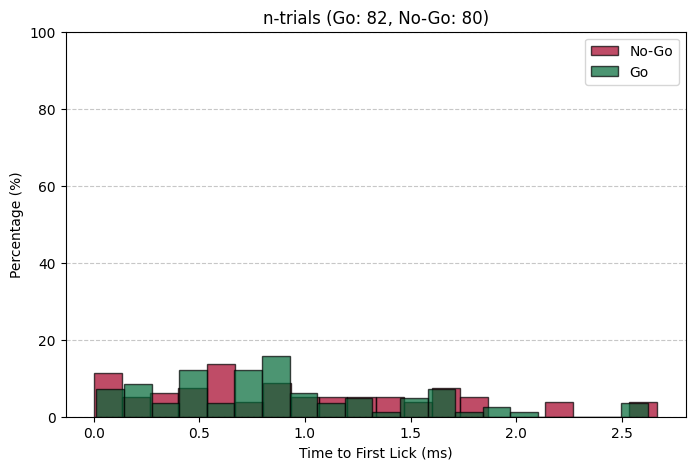

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A4\GNG\Session Data\G1A4_GNG_20241202_095238.mat


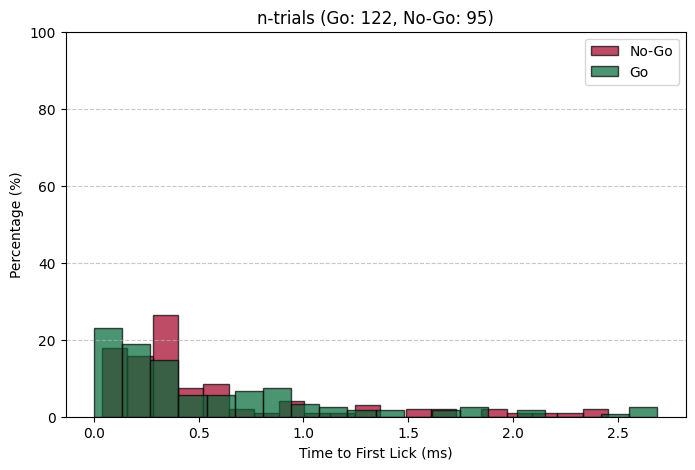

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A2\GNG\Session Data\G1A2_GNG_20241202_112349.mat


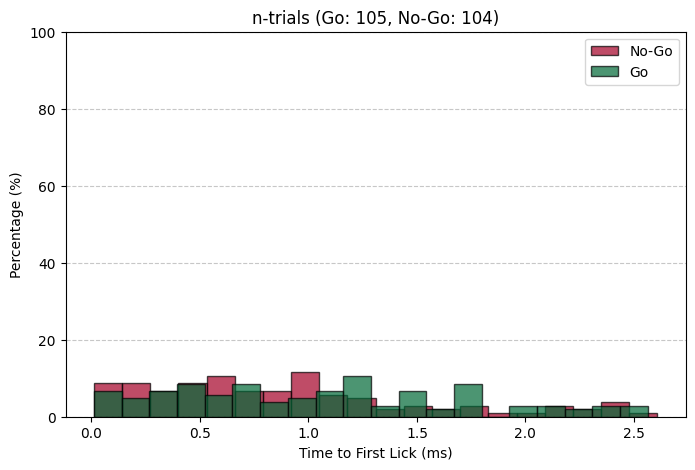

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A4\GNG\Session Data\G1A4_GNG_20241202_120638.mat


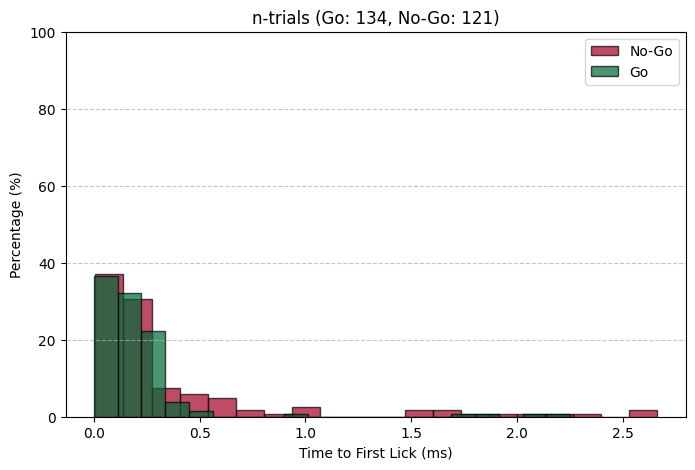

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A2\GNG\Session Data\G1A2_GNG_20241203_085624.mat


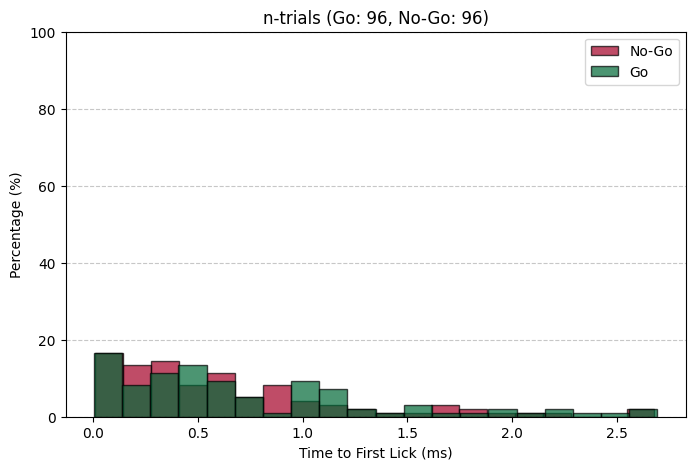

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A4\GNG\Session Data\G1A4_GNG_20241203_093556.mat


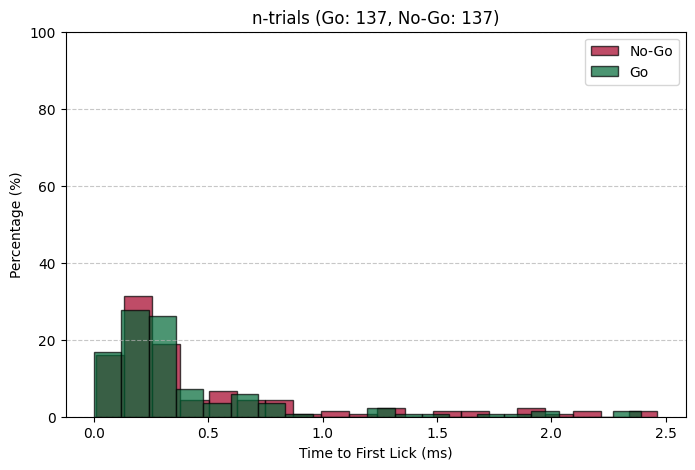

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A2\GNG\Session Data\G1A2_GNG_20241203_105227.mat


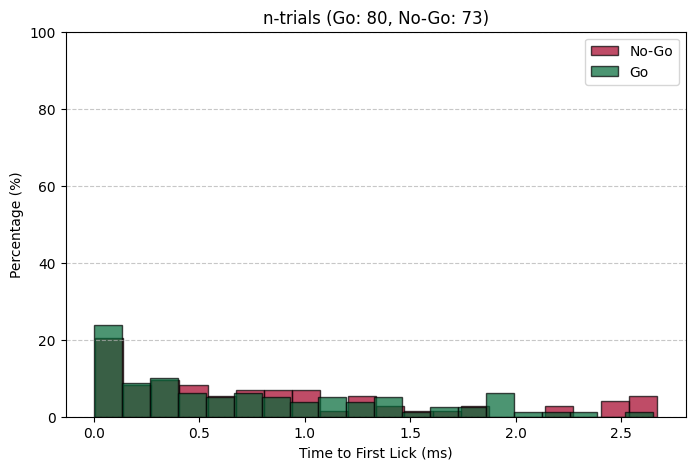

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A4\GNG\Session Data\G1A4_GNG_20241203_112404.mat


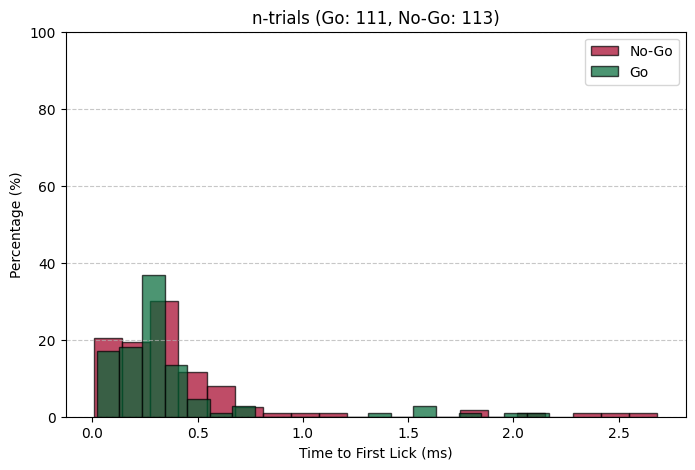

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A2\GNG\Session Data\G1A2_GNG_20241204_085451.mat


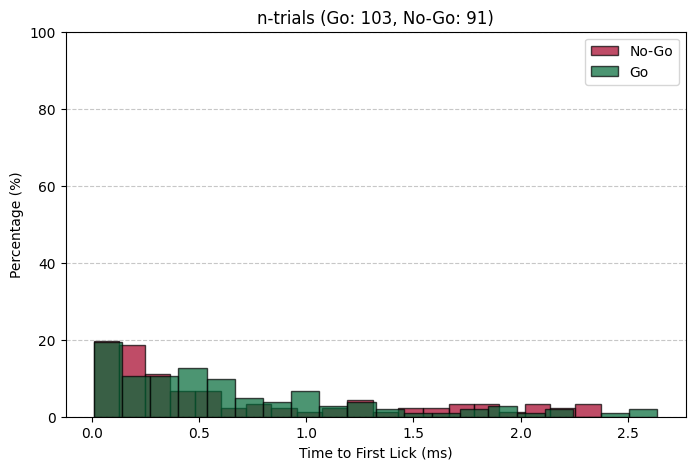

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A4\GNG\Session Data\G1A4_GNG_20241204_093336.mat


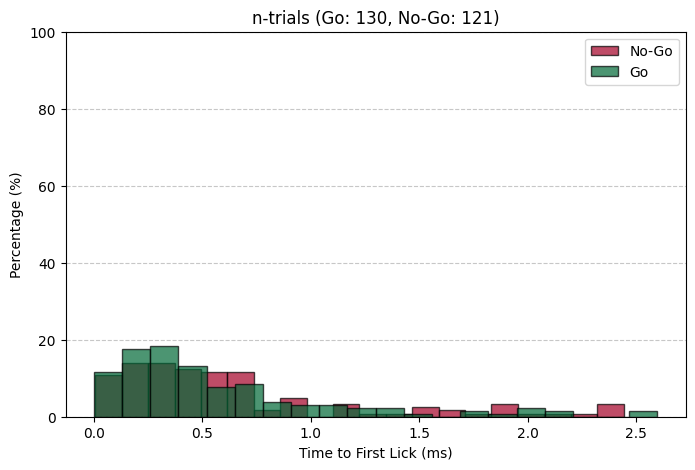

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A2\GNG\Session Data\G1A2_GNG_20241204_102652.mat


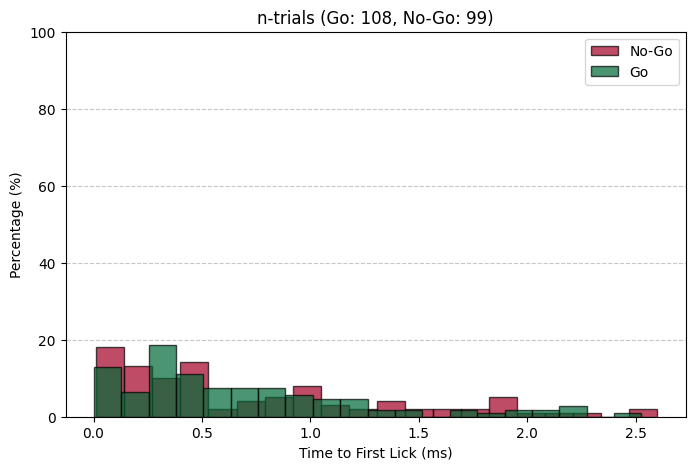

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A4\GNG\Session Data\G1A4_GNG_20241204_110326.mat


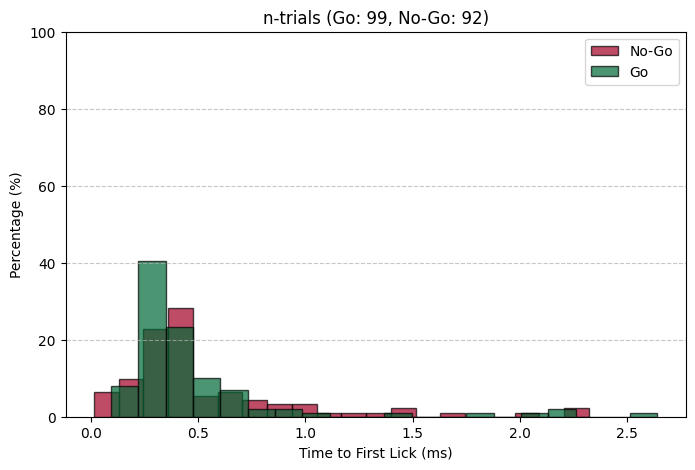

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A2\GNG\Session Data\G1A2_GNG_20241205_091512.mat


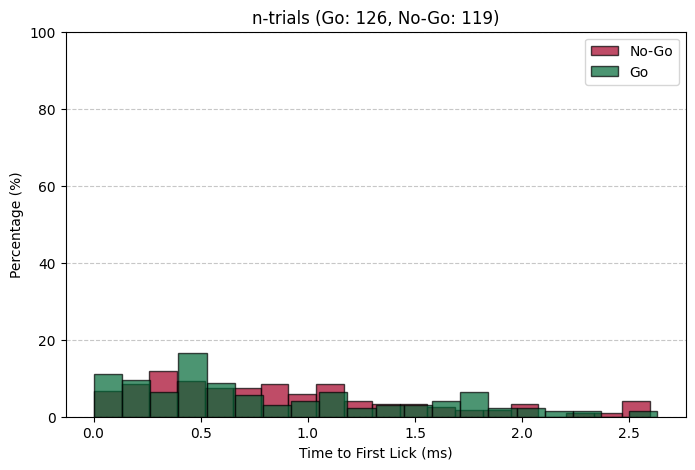

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A4\GNG\Session Data\G1A4_GNG_20241205_120547.mat


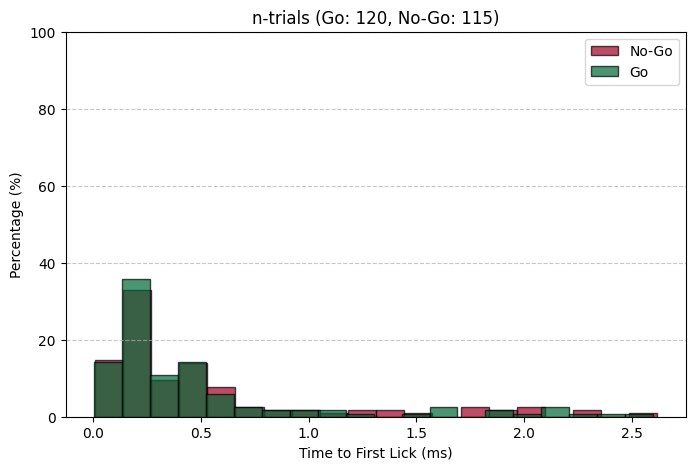

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A2\GNG\Session Data\G1A2_GNG_20241205_124359.mat


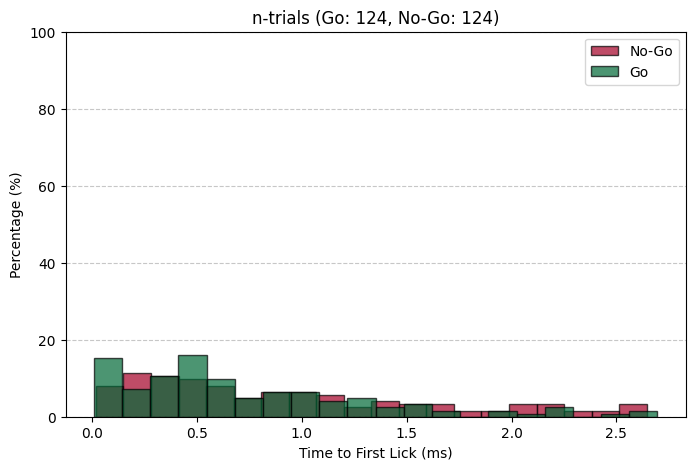

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A2\GNG\Session Data\G1A2_GNG_20241208_092205.mat


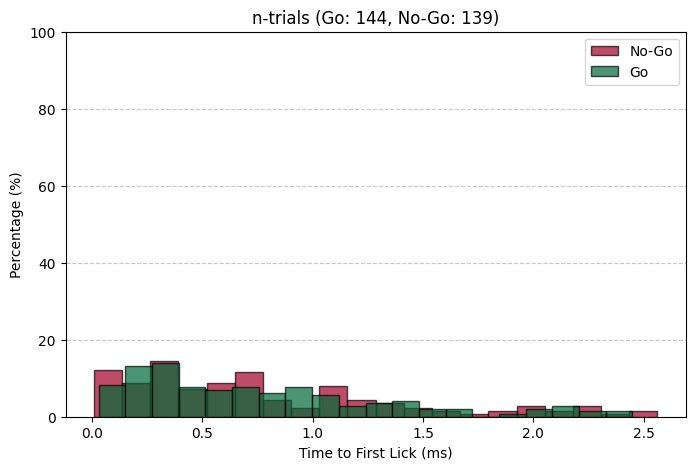

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A4\GNG\Session Data\G1A4_GNG_20241208_100629.mat


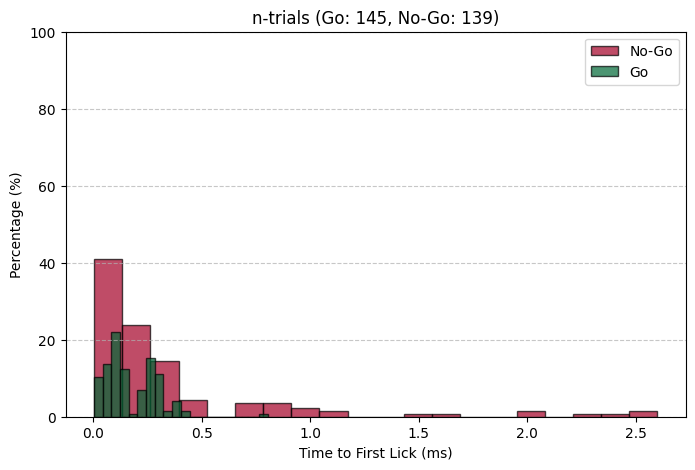

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A2\GNG\Session Data\G1A2_GNG_20241208_110416.mat


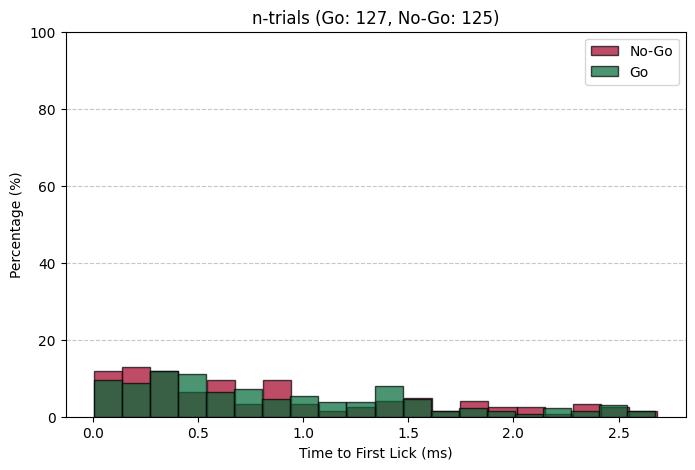

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A4\GNG\Session Data\G1A4_GNG_20241208_114632.mat


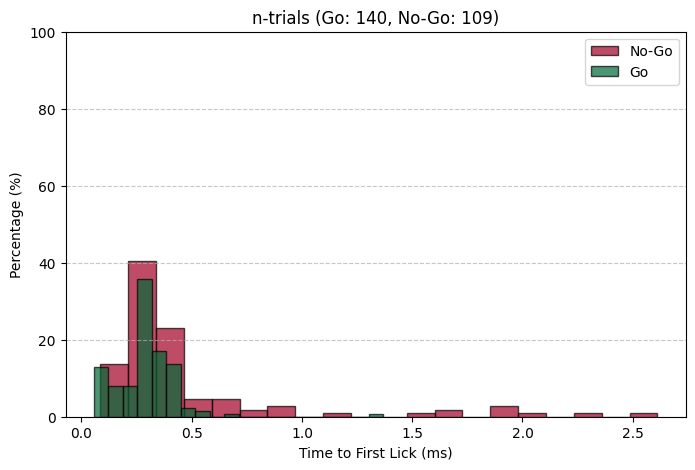

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A2\GNG\Session Data\G1A2_GNG_20241208_130544.mat


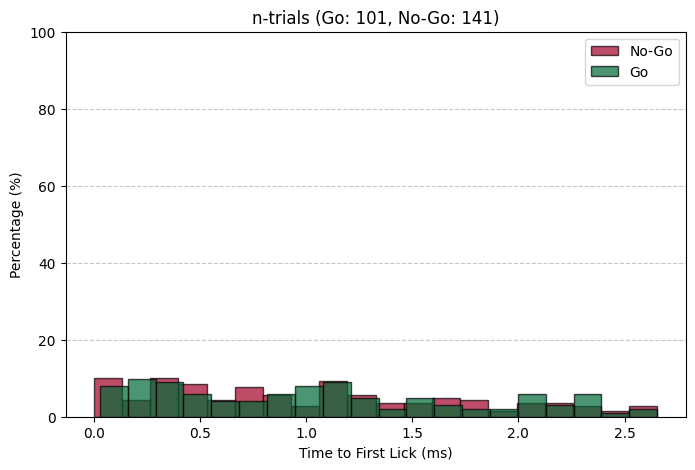

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A2\GNG\Session Data\G1A2_GNG_20241209_084943.mat


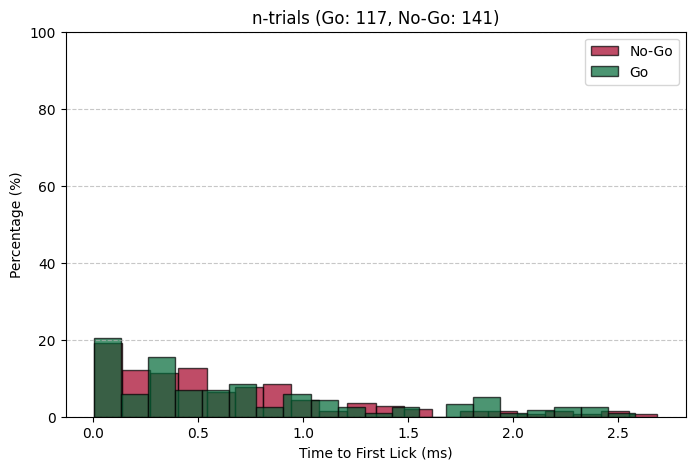

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A4\GNG\Session Data\G1A4_GNG_20241209_093411.mat


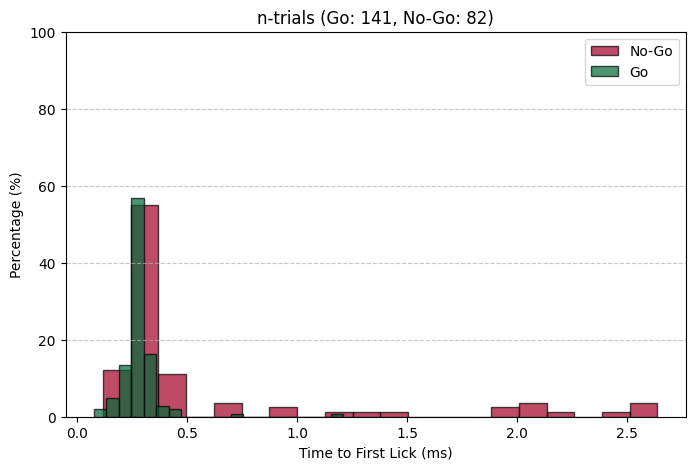

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A2\GNG\Session Data\G1A2_GNG_20241209_101120.mat


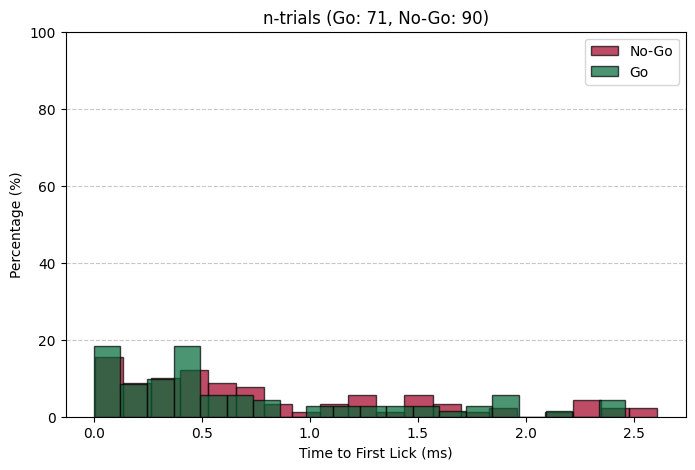

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A4\GNG\Session Data\G1A4_GNG_20241209_104342.mat


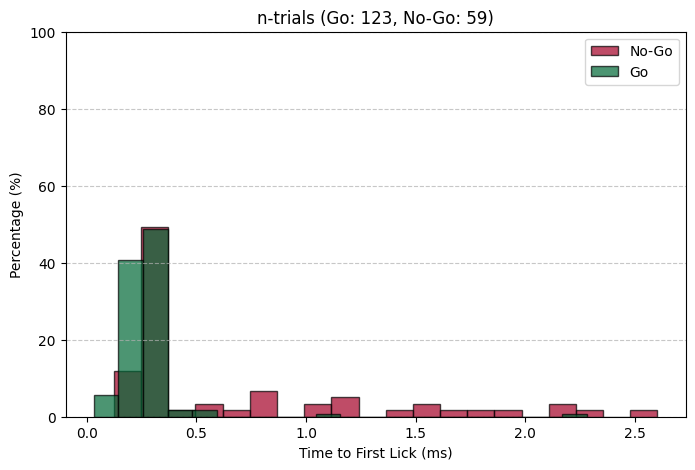

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A2\GNG\Session Data\G1A2_GNG_20241210_085346.mat


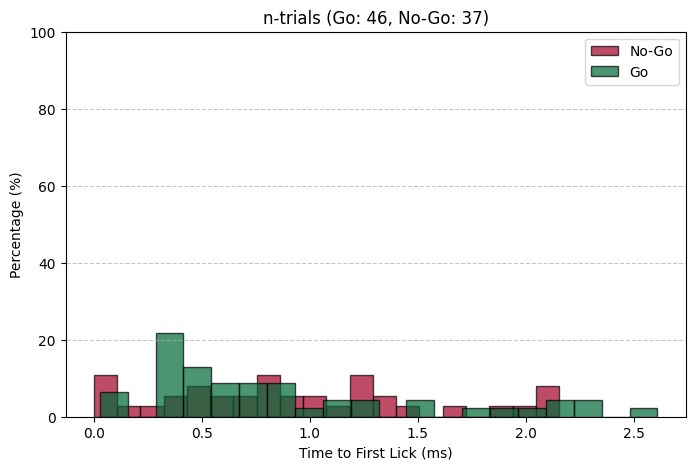

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A4\GNG\Session Data\G1A4_GNG_20241210_091131.mat


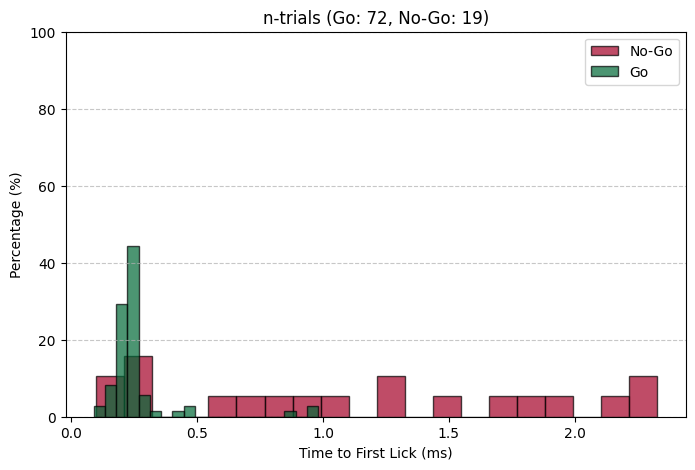

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A2\GNG\Session Data\G1A2_GNG_20241210_100318.mat


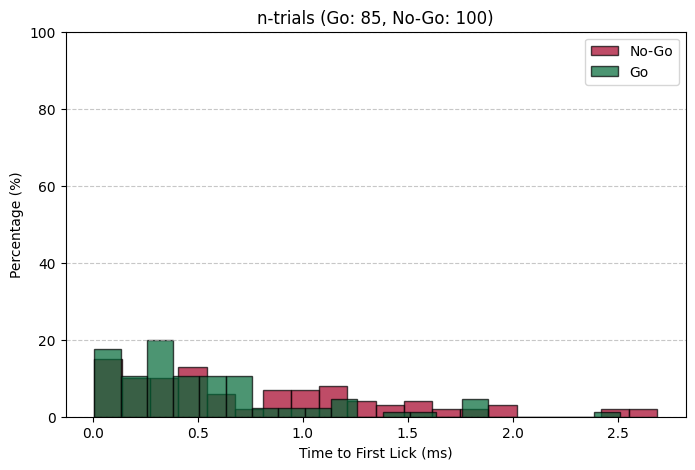

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A4\GNG\Session Data\G1A4_GNG_20241210_103534.mat


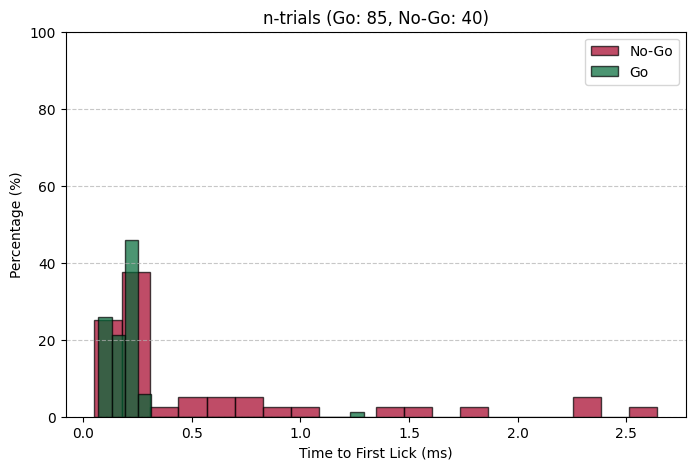

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A2\GNG\Session Data\G1A2_GNG_20241211_084659.mat


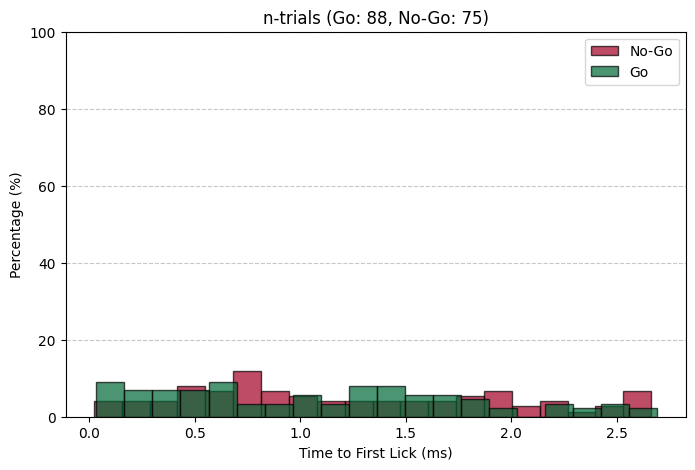

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A4\GNG\Session Data\G1A4_GNG_20241211_095041.mat


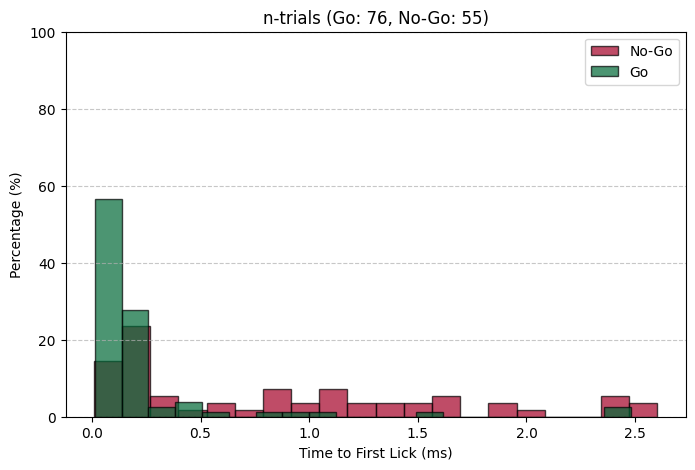

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A2\GNG\Session Data\G1A2_GNG_20241211_101829.mat


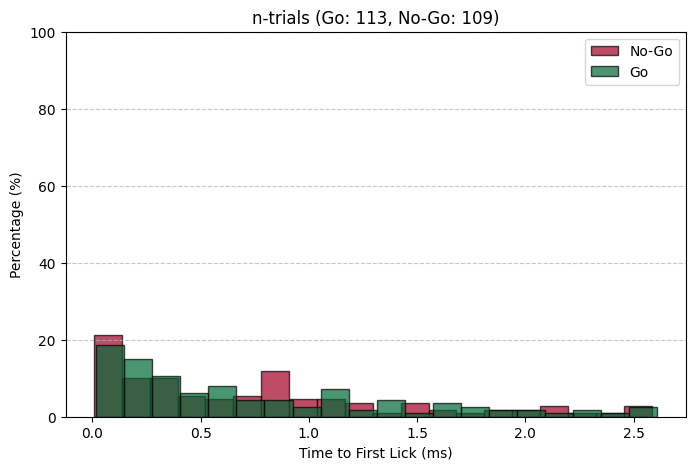

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A4\GNG\Session Data\G1A4_GNG_20241211_110250.mat


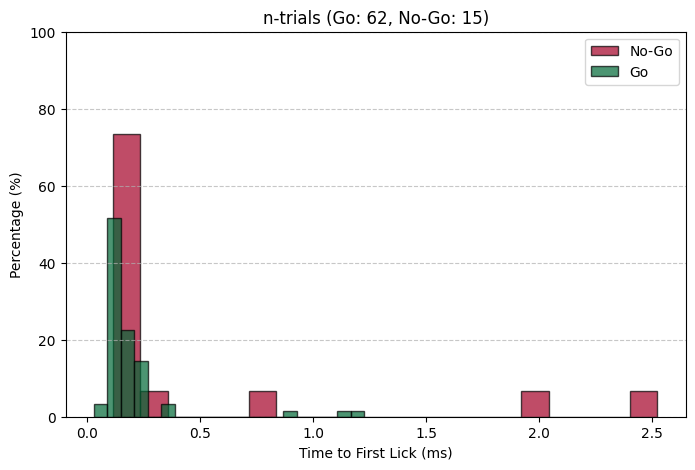

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A2\GNG\Session Data\G1A2_GNG_20241212_084458.mat


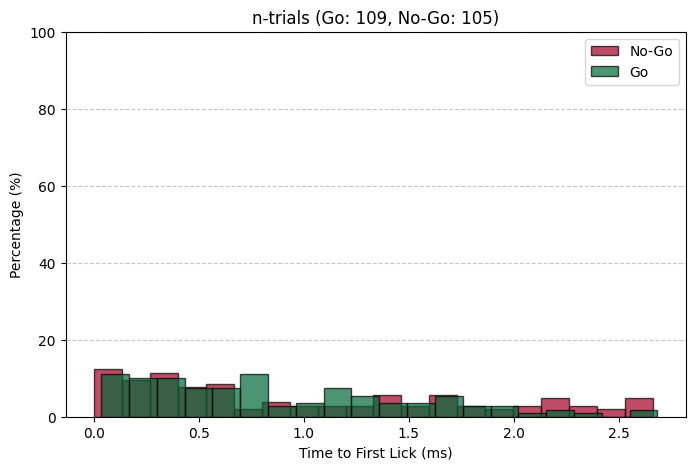

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A4\GNG\Session Data\G1A4_GNG_20241212_092639.mat


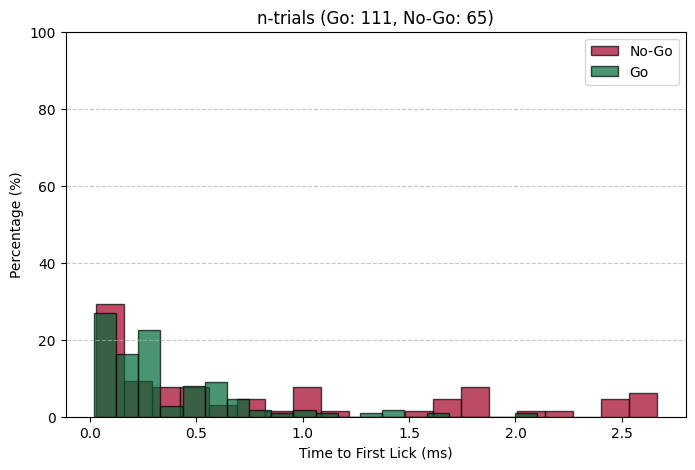

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A2\GNG\Session Data\G1A2_GNG_20241212_105834.mat


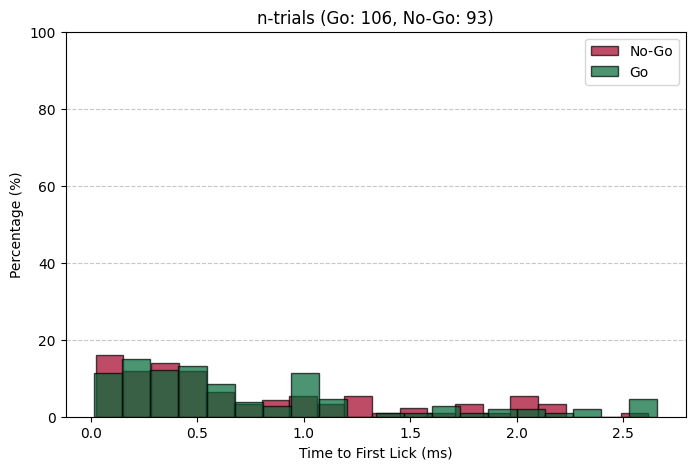

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A4\GNG\Session Data\G1A4_GNG_20241212_113724.mat


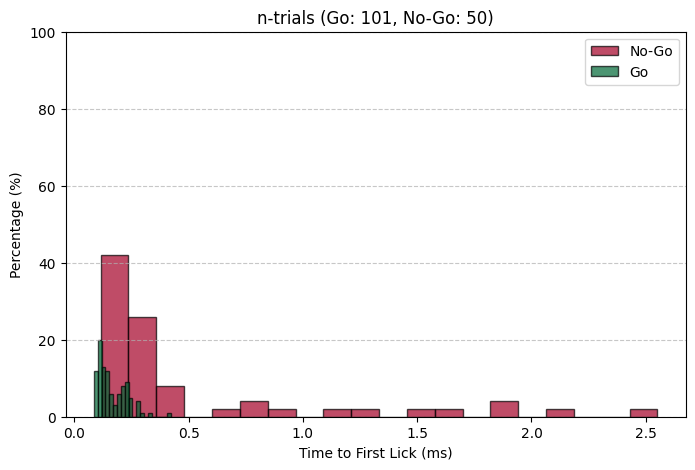

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A4\GNG\Session Data\G1A4_GNG_20241215_102504.mat


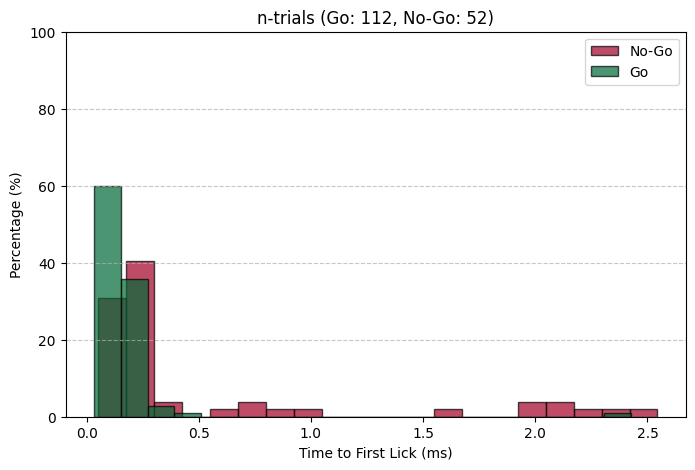

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A2\GNG\Session Data\G1A2_GNG_20241215_133323.mat


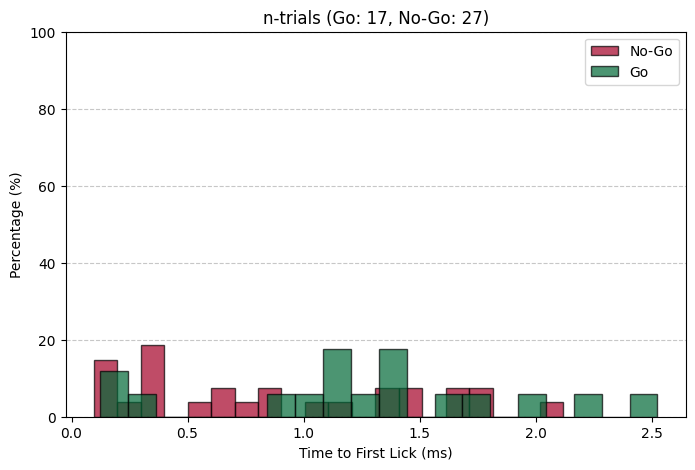

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A2\GNG\Session Data\G1A2_GNG_20241216_130623.mat


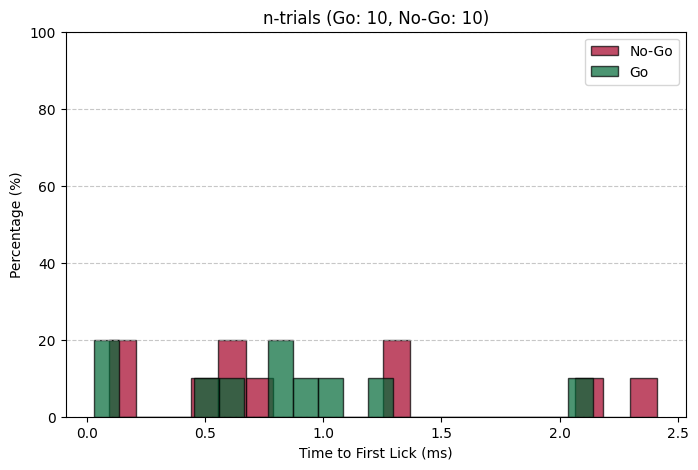

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A2\GNG\Session Data\G1A2_GNG_20241216_132101.mat


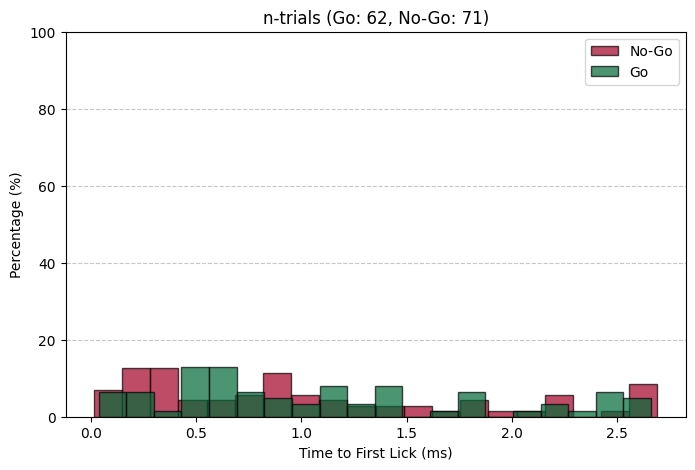

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A4\GNG\Session Data\G1A4_GNG_20241216_144420.mat


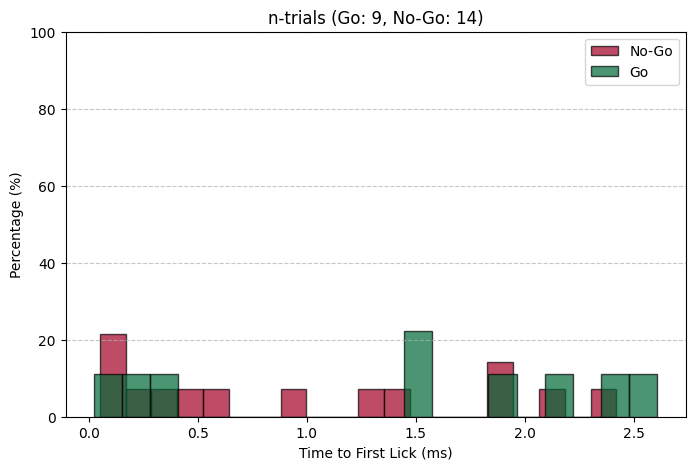

Processing file: Z:/Shared/Amichai/Behavior/data/Group_1\G1A4\GNG\Session Data\G1A4_GNG_20241216_150037.mat


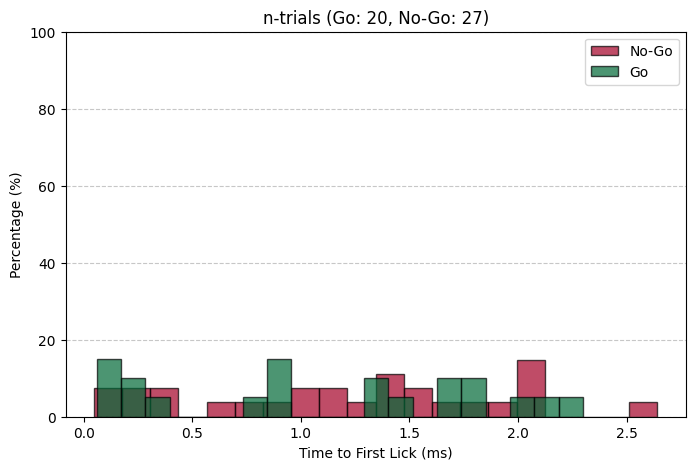

Processing file: Z:/Shared/Amichai/Behavior/data/Group_2\G1A2\GNG\Session Data\G1A2_GNG_20241125_123642.mat


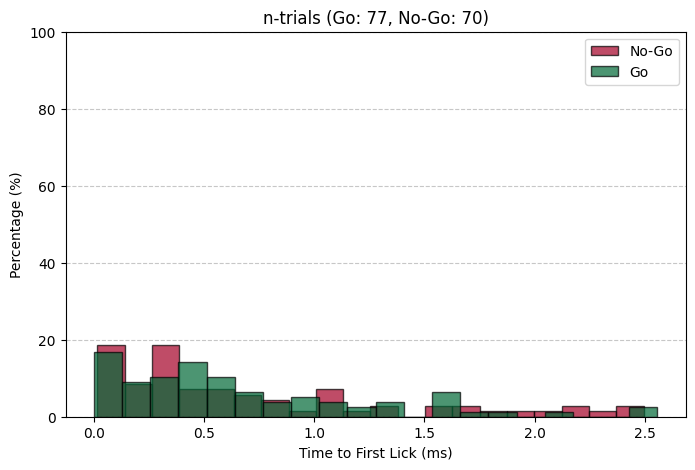

Processing file: Z:/Shared/Amichai/Behavior/data/Group_2\G1A2\GNG\Session Data\G1A2_GNG_20241126_083915.mat


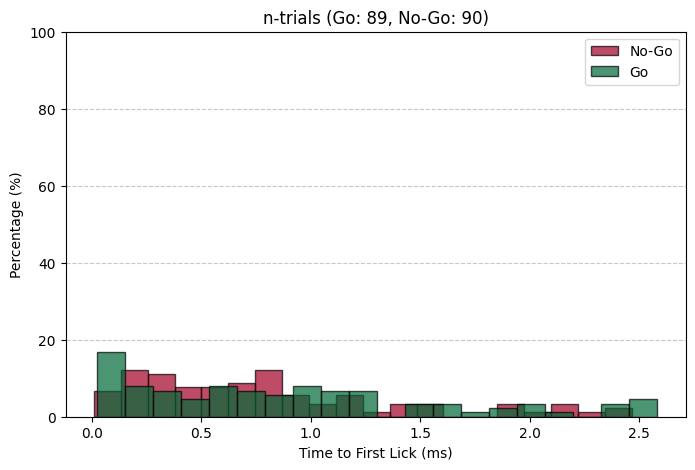

Processing file: Z:/Shared/Amichai/Behavior/data/Group_2\G1A2\GNG\Session Data\G1A2_GNG_20241126_101313.mat


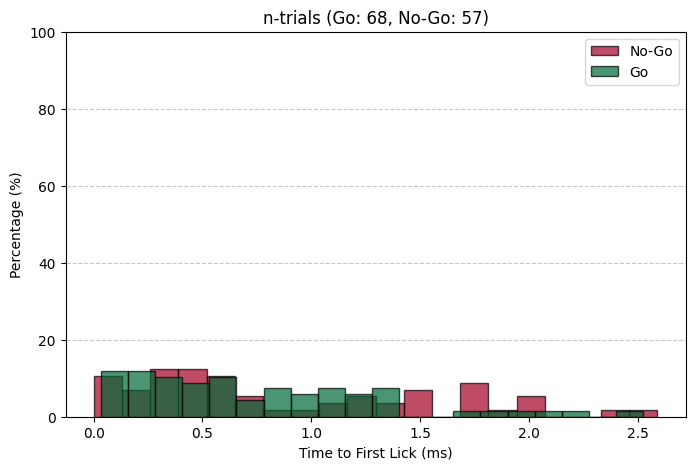

Processing file: Z:/Shared/Amichai/Behavior/data/Group_2\G1A2\GNG\Session Data\G1A2_GNG_20241127_084830.mat


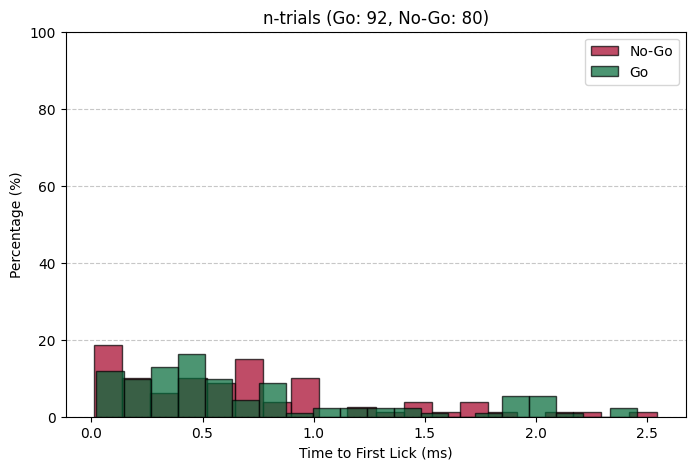

Processing file: Z:/Shared/Amichai/Behavior/data/Group_2\G1A2\GNG\Session Data\G1A2_GNG_20241201_084900.mat


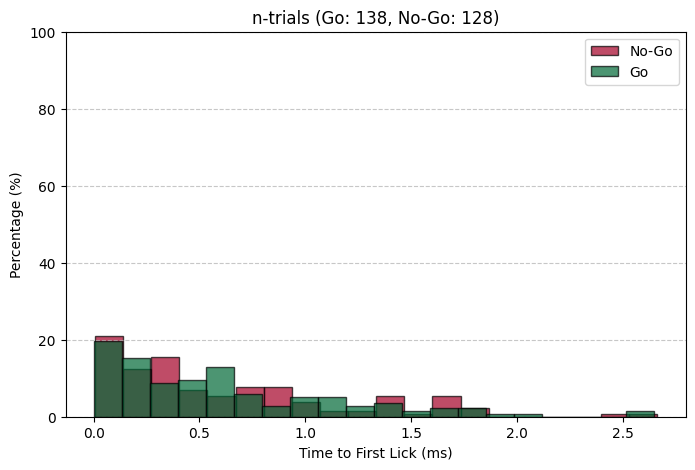

Processing file: Z:/Shared/Amichai/Behavior/data/Group_2\G1A2\GNG\Session Data\G1A2_GNG_20241201_121023.mat


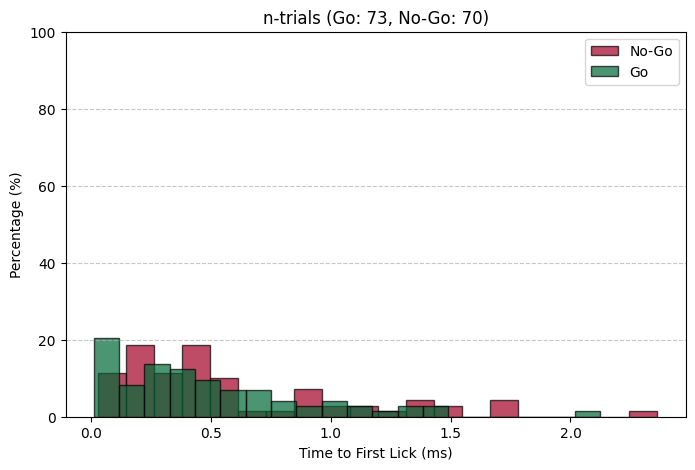

Processing file: Z:/Shared/Amichai/Behavior/data/Group_2\G1A2\GNG\Session Data\G1A2_GNG_20241202_090421.mat


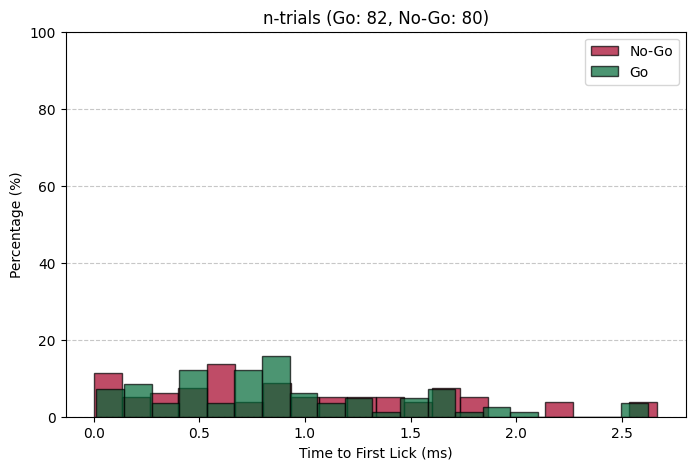

Processing file: Z:/Shared/Amichai/Behavior/data/Group_2\G1A2\GNG\Session Data\G1A2_GNG_20241202_112349.mat


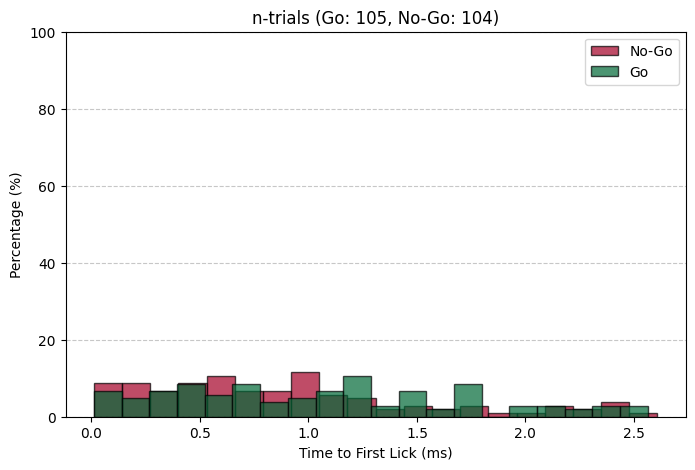

Processing file: Z:/Shared/Amichai/Behavior/data/Group_2\G1A2\GNG\Session Data\G1A2_GNG_20241203_085624.mat


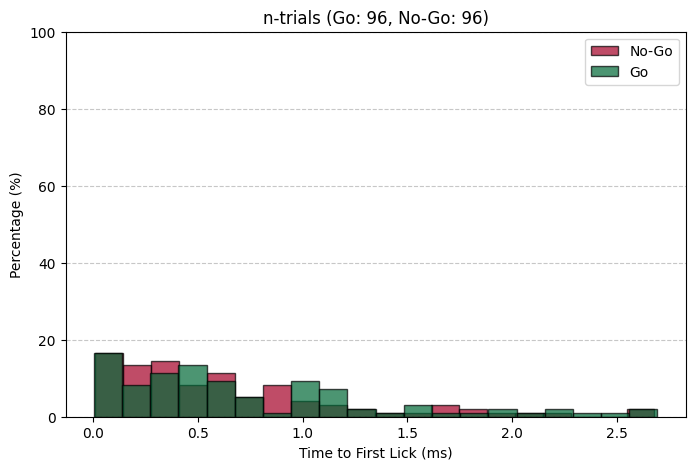

Processing file: Z:/Shared/Amichai/Behavior/data/Group_2\G1A2\GNG\Session Data\G1A2_GNG_20241203_105227.mat


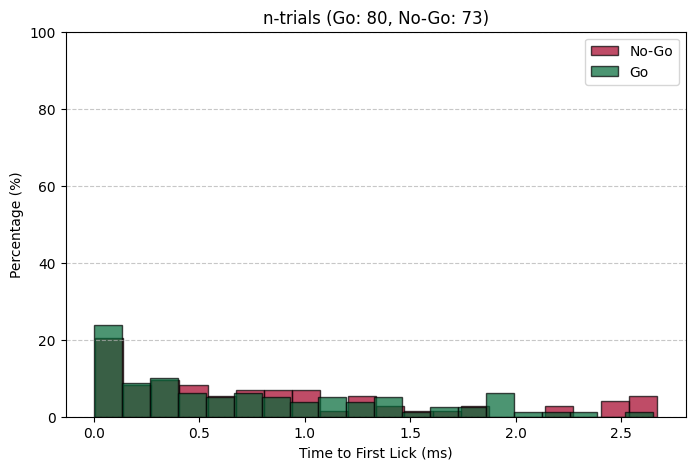

Processing file: Z:/Shared/Amichai/Behavior/data/Group_2\G1A2\GNG\Session Data\G1A2_GNG_20241204_085451.mat


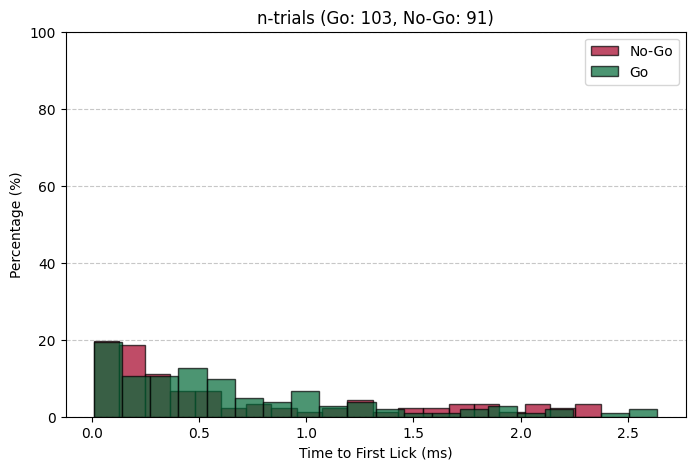

Processing file: Z:/Shared/Amichai/Behavior/data/Group_2\G1A2\GNG\Session Data\G1A2_GNG_20241204_102652.mat


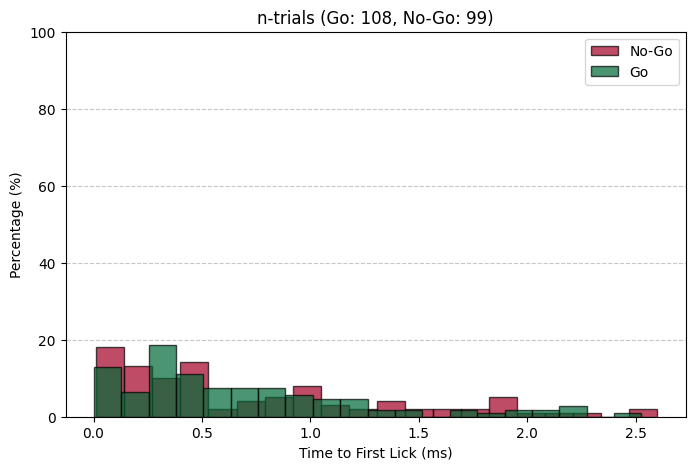

Processing file: Z:/Shared/Amichai/Behavior/data/Group_2\G1A2\GNG\Session Data\G1A2_GNG_20241205_091512.mat


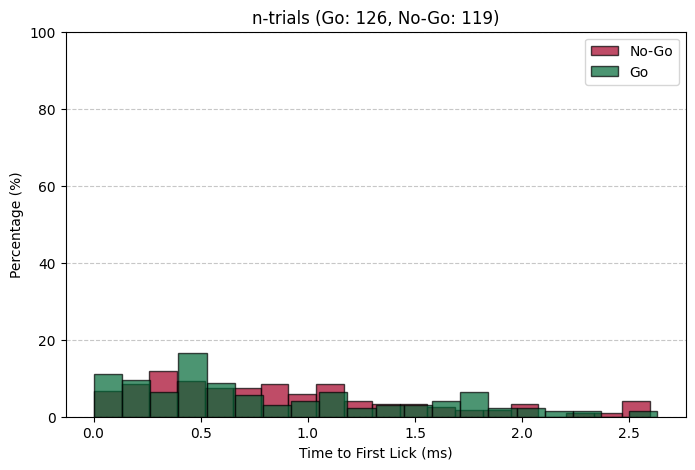

Processing file: Z:/Shared/Amichai/Behavior/data/Group_2\G1A2\GNG\Session Data\G1A2_GNG_20241205_124359.mat


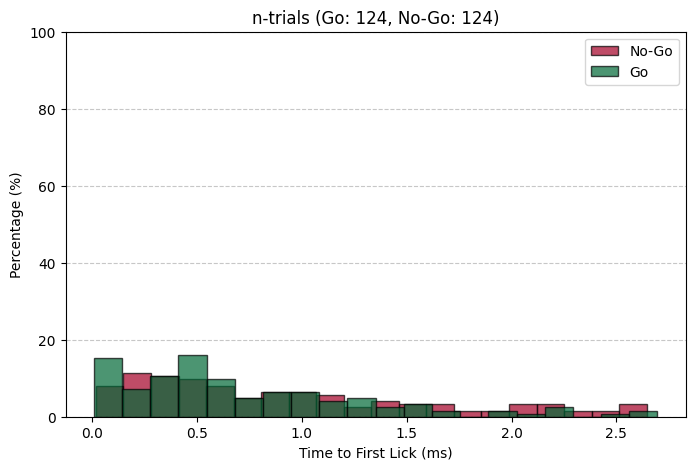

Processing file: nan
Critical error in file nan: expected str, bytes or os.PathLike object, not float


TypeError: cannot unpack non-iterable NoneType object

In [20]:
import pandas as pd
import numpy as np

# Ensure the columns exist with appropriate data types
cat_data["Psychometric Fit"] = None
cat_data["TTFL Fit"] = None
cat_data = cat_data.astype({"Psychometric Fit": "object", "TTFL Fit": "object"})

# Lists to store results
psychometric_results = []
ttfl_results = []

# Iterate efficiently
for index, row in cat_data.iterrows():
    path = row.get('FilePath', None)


    # Call preprocessing function
    time_to_lick, licks, outcome, trial_types, stimuli, unique_stims, grouped_data, TTFL_data_mean, lick_rates = read_and_preprocess(path)
    # plot_lick_raster_and_histogram(time_to_lick, trial_types)
    time2lick(time_to_lick, trial_types,  plot = True)

    try:
        # Psychometric Fit for Lick Rates
        x0, slope_at_midpoint, slope_at_median = psychometric_fitting(unique_stims, lick_rates, toplim=1.1, plot=False)
        
        # Store results
        psychometric_results.append({
            "data": lick_rates,
            "x0": x0,
            "slope_at_midpoint": slope_at_midpoint,
            "slope_at_median": slope_at_median
        })
    except:
        # Store results
        psychometric_results.append({
            "data": [],
            "x0": [],
            "slope_at_midpoint": [],
            "slope_at_median": []
        })
    
    try:
        # TTFL Fit
        TTFL_x0, TTFL_slope_at_midpoint, TTFL_slope_at_median = psychometric_fitting(unique_stims, TTFL_data_mean, toplim=1.5, plot=False)
    
    
        ttfl_results.append({
            "TTFL_data": TTFL_data_mean.tolist() if isinstance(TTFL_data_mean, np.ndarray) else TTFL_data_mean,
            "TTFL_x0": TTFL_x0,
            "TTFL_slope_at_midpoint": TTFL_slope_at_midpoint,
            "TTFL_slope_at_median": TTFL_slope_at_median
        })

    except:
         ttfl_results.append({
            "TTFL_data": [],
            "TTFL_x0": [],
            "TTFL_slope_at_midpoint": [],
            "TTFL_slope_at_median": []
        })
        
# Assign results efficiently
cat_data["Psychometric Fit"] = psychometric_results
cat_data["TTFL Fit"] = ttfl_results


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Ensure a fresh copy to avoid modifying original data
cat_data = cat_data.copy()

### Function to remove invalid data ###
def remove_invalid_data(df, fit_column):
    return df.loc[~df[fit_column].apply(lambda data: np.any(data['data'] == 0))].copy()

### Function to extract a specific feature ###
def extract_feature(df, fit_column, feature_name, new_column_name):
    df = df.copy()
    df.loc[:, new_column_name] = df[fit_column].apply(lambda x: x[feature_name])
    return df

### Function to remove outliers using IQR ###
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)].copy()

### Function to assign session indices ###
def assign_session_index(df):
    df = df.copy()
    df["Session_Index"] = df.groupby("MouseName").cumcount()
    return df

### Function to plot progress ###
def plot_progress(df, y_column, ylabel, title):
    grouped = df.groupby("MouseName")

    plt.figure(figsize=(10, 6))

    # Plot each mouse's line in gray with 50% transparency
    for mouse, data in grouped:
        plt.plot(data["Session_Index"], data[y_column], color="gray", alpha=0.5, linewidth=0.5)

    # Compute and plot the average trend line
    mean_values = df.groupby("Session_Index")[y_column].mean()
    plt.plot(mean_values.index, mean_values, color="black", linewidth=2, label="Average Trend")

    # Add dashed horizontal line at y=0
    plt.axhline(y=0, color="gray", linestyle="dashed", linewidth=1)

    # Labels and title
    plt.xlabel("Session Index (Per Mouse)")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

### Process and Plot for Different Metrics ###

# Remove invalid data
cat_data = remove_invalid_data(cat_data, "Psychometric Fit")

# Extract and Process "slope_at_midpoint"
cat_data = extract_feature(cat_data, "Psychometric Fit", "slope_at_midpoint", "slope_at_midpoint")
cat_data1 = remove_outliers(cat_data, "slope_at_midpoint")
cat_data1 = assign_session_index(cat_data1)
plot_progress(cat_data1, "slope_at_midpoint", "Slope at Midpoint", "Progress of Slope at Midpoint Over Mice")

# Extract and Process "TTFL_slope_at_midpoint"
cat_data2 = extract_feature(cat_data, "TTFL Fit", "TTFL_slope_at_midpoint", "TTFL_slope_at_midpoint")
cat_data2 = remove_outliers(cat_data2, "TTFL_slope_at_midpoint")
cat_data2 = assign_session_index(cat_data2)
plot_progress(cat_data2, "TTFL_slope_at_midpoint", "TTFL Slope at Midpoint", "Progress of TTFL Slope at Midpoint Over Mice")

# Extract and Process "x0_distance"
cat_data3 = extract_feature(cat_data, "Psychometric Fit", "x0", "x0_distance")
cat_data3["x0_distance"] = abs(cat_data3["x0_distance"] - 1)
# cat_data = remove_outliers(cat_data, "x0_distance")
cat_data3 = assign_session_index(cat_data3)
plot_progress(cat_data3, "x0_distance", "Distance from x0 to Boundary (1)", "Progress of x0 Distance Over Mice")

# Extract and Process "TTFL_x0_distance"
cat_data4 = extract_feature(cat_data, "TTFL Fit", "TTFL_x0", "TTFL_x0_distance")
cat_data4["TTFL_x0_distance"] = abs(cat_data4["TTFL_x0_distance"] - 1)
cat_data4 = remove_outliers(cat_data4, "TTFL_x0_distance")
cat_data4 = assign_session_index(cat_data4)
plot_progress(cat_data4, "TTFL_x0_distance", "Distance from TTFL_x0 to Boundary (1)", "Progress of TTFL x0 Distance Over Mice")
